# Main Objective

The purpose of this project is to tell the difference between photographs of natural scenes and pictures generated by artificial intelligence (AI). The overall context of this project is to answer the necessity to authenticate image data in an era where AI-based synthetic data generation has become widespread. This problem is addressed by means of deep neural networks to automatically classify images into `REAL` and `FAKE` categories.

The first question one could ask is "Can a human visually distinguish the two image classes?". Other factor may hinder (or at the contrary, facilitate) the classification task, such as the intrinsic semantic, structural, and color-wise diversity of each dataset, the potential artifacts caused either by JPEG compression or by the presence of alpha-numeric symbols, or the hypothesis that natural image may live in a less sparse embedding space compared to AI-generated samples.

Let's find out how well deep convolutional neural networks can recognize natural images from, hem, AI-generated ones.

# Setup environment

In [ ]:
%%capture
!pip install --upgrade tensorflow

In [ ]:
%%capture --no-display
import os
import warnings
import glob
import random
from tensorflow import keras
from keras.metrics import BinaryAccuracy, Precision, Recall
from sklearn.metrics import roc_curve, auc, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from matplotlib import image as img
from tqdm import tqdm

In [ ]:
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
# Impose a seed for reproducibility
random_seed = 421
random.seed(random_seed)
np.random.seed(random_seed)

# Dataset

## Dataset description

The `REAL` images are from the CIFAR-10 dataset [1], with the following properties:

- Image type: photograps of the real world
- Image size: 32×32 pixels, with 3 channels (RGB)
- Total number of samples: 60,000
- Train/Test split: 50,000/10,000
- Number of classes: 10 (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck), in equal proportion

The `FAKE` images are from the CIFAKE dataset [2], with the following properties:

- Image type: synthetic pictures generated by AI
- Image size: 32×32 pixels, with 3 channels (RGB)
- Total number of samples: 60,000
- Train/Test split: 50,000/10,000
- Number of classes: 10 (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck), in equal proportion


## Credits for the dataset

> [1] Krizhevsky, A., & Hinton, G. (2009). Learning multiple layers of features from tiny images.

> [2] Bird, J.J. and Lotfi, A. (2024). CIFAKE: Image Classification and Explainable Identification of AI-Generated Synthetic Images.

## Link to download the dataset

[https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images](https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images)

## Dataloader

In [ ]:
# Set the local path
path_dataset = '???' # Enter your own local path here

In [ ]:
# Derive the train/test and real/fake paths
path_dataset_train = os.path.join(path_dataset, 'train')
path_dataset_train_real = os.path.join(path_dataset_train, 'REAL')
path_dataset_train_fake = os.path.join(path_dataset_train, 'FAKE')
path_dataset_test = os.path.join(path_dataset, 'test')
path_dataset_test_real = os.path.join(path_dataset_test, 'REAL')
path_dataset_test_fake = os.path.join(path_dataset_test, 'FAKE')

In [ ]:
# List the samples
samples_list_train_real = list(glob.glob(os.path.join(path_dataset_train_real, '*.jpg')))
samples_list_test_real = glob.glob(os.path.join(path_dataset_test_real, '*.jpg'))
samples_list_train_fake = glob.glob(os.path.join(path_dataset_train_fake, '*.jpg'))
samples_list_test_fake = glob.glob(os.path.join(path_dataset_test_fake, '*.jpg'))

In [8]:
# Count the number of samples and ensure the distribution is balanced
print('Number of samples:')
print('Train split \t Real images: \t {}'.format(len(samples_list_train_real)))
print('Test split \t Real images: \t {}'.format(len(samples_list_test_real)))
print('Train split \t Fake images: \t {}'.format(len(samples_list_train_fake)))
print('Test split \t Fake images: \t {}'.format(len(samples_list_test_fake)))

Number of samples:
Train split 	 Real images: 	 50000
Test split 	 Real images: 	 10000
Train split 	 Fake images: 	 50000
Test split 	 Fake images: 	 10000


In [ ]:
# Apply in-place random shuffling
random.shuffle(samples_list_train_real)
random.shuffle(samples_list_test_real)
random.shuffle(samples_list_train_fake)
random.shuffle(samples_list_test_fake)

In [ ]:
# Dataloader properties
image_height, image_width = 32, 32
batch_size = 64
validation_split = 0.2

# Dataloader for the train split
train_set_dataloader = tf.keras.utils.image_dataset_from_directory(
    path_dataset_train,
    shuffle=True,
    seed=random_seed,
    validation_split=1-validation_split,
    subset='training',    
    batch_size=batch_size,
    image_size=(image_height, image_width))
print('Classes for the train split: {}'.format(train_set_dataloader.class_names))

# Dataloader for the validation split
validation_set_dataloader = tf.keras.utils.image_dataset_from_directory(
    path_dataset_train,
    shuffle=True,
    seed=random_seed,
    validation_split=validation_split,
    subset='validation',    
    batch_size=batch_size,
    image_size=(image_height, image_width))
print('Classes for the validation split: {}'.format(validation_set_dataloader.class_names))

# Dataloader for the test split
test_set_dataloader = tf.keras.utils.image_dataset_from_directory(
    path_dataset_test,
    shuffle=True,
    seed=random_seed,
    batch_size=batch_size,
    image_size=(image_height, image_width))
print('Classes for the test split: {}'.format(test_set_dataloader.class_names))

```
Found 100000 files belonging to 2 classes.
Using 20000 files for training.
Classes for the train split: ['FAKE', 'REAL']
Found 100000 files belonging to 2 classes.
Using 20000 files for validation.
Classes for the validation split: ['FAKE', 'REAL']
Found 20000 files belonging to 2 classes.
Classes for the test split: ['FAKE', 'REAL']
```

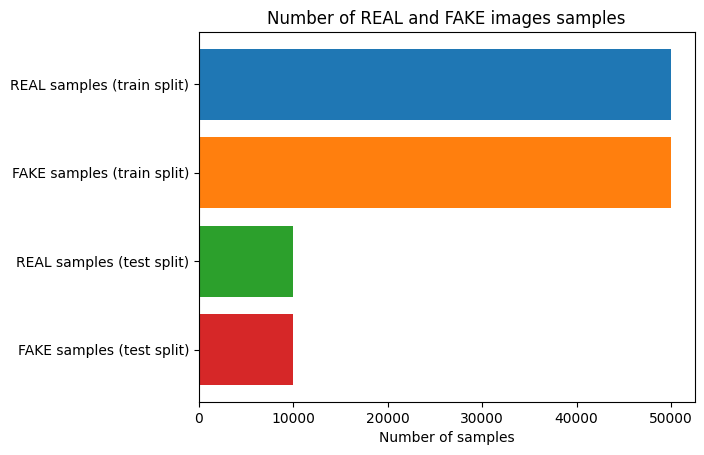

In [11]:
fig = plt.figure()
plt.barh(0, width=len(samples_list_train_real))
plt.barh(1, width=len(samples_list_train_fake))
plt.barh(2, width=len(samples_list_test_real))
plt.barh(3, width=len(samples_list_test_fake))
plt.gca().invert_yaxis()
plt.yticks([0, 1, 2, 3], ['REAL samples (train split)', 'FAKE samples (train split)', 'REAL samples (test split)', 'FAKE samples (test split)'])
plt.xlabel('Number of samples')
plt.title('Number of REAL and FAKE images samples')
plt.show()

## Display a few random samples

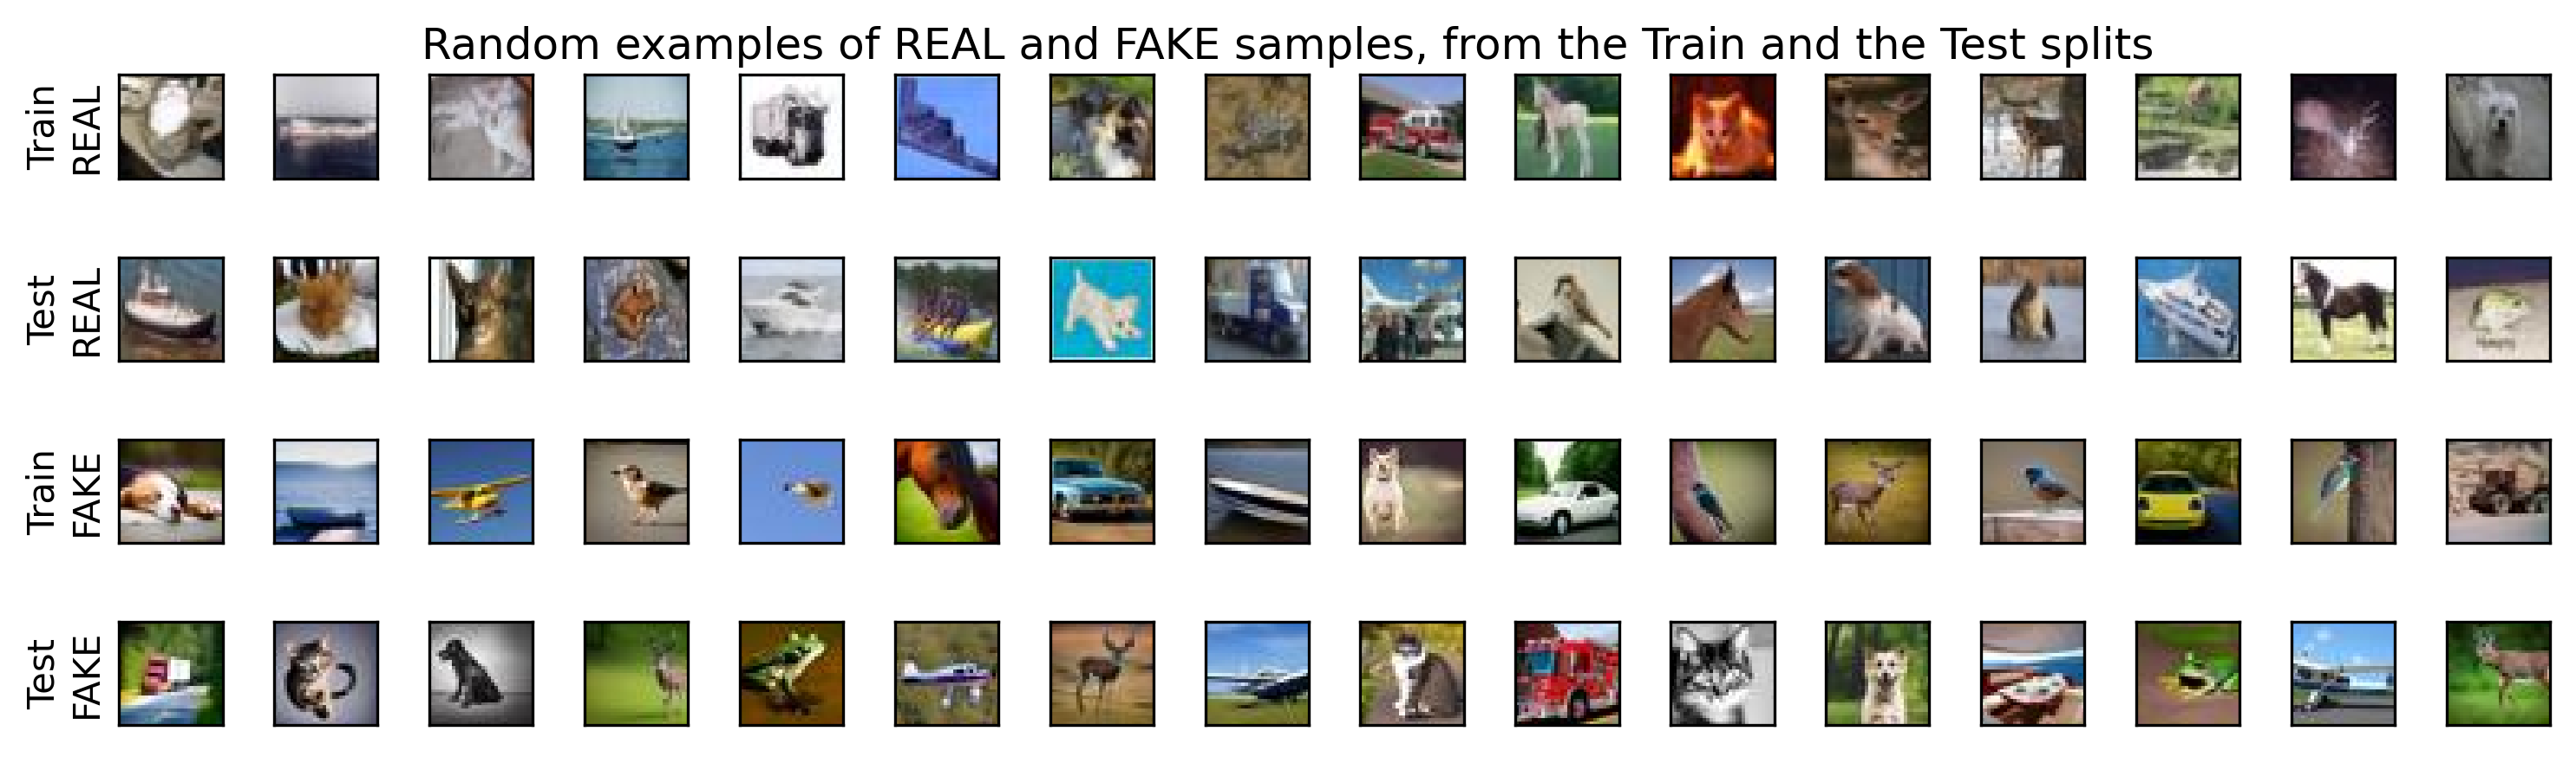

In [12]:
number_of_displayed_samples = 16

fig, ax = plt.subplots(4, number_of_displayed_samples)
fig.set_dpi(300)
fig.set_size_inches(10, 3, forward=True)

for index in range(number_of_displayed_samples):

    axx = ax[0, index]
    fig.sca(axx)
    plt.imshow(img.imread(os.path.join(path_dataset_train_real, samples_list_train_real[index])))
    plt.ylabel('Train\nREAL') if index==0 else None

    axx = ax[1, index]
    fig.sca(axx)
    plt.imshow(img.imread(os.path.join(path_dataset_test_real, samples_list_test_real[index])))
    plt.ylabel('Test\nREAL') if index==0 else None

    axx = ax[2, index]
    fig.sca(axx)
    plt.imshow(img.imread(os.path.join(path_dataset_train_fake, samples_list_train_fake[index])))
    plt.ylabel('Train\nFAKE') if index==0 else None

    axx = ax[3, index]
    fig.sca(axx)
    plt.imshow(img.imread(os.path.join(path_dataset_test_fake, samples_list_test_fake[index])))
    plt.ylabel('Test\nFAKE') if index==0 else None

[axx.set_xticks([]) for axx in ax.ravel()]
[axx.set_yticks([]) for axx in ax.ravel()]
plt.tight_layout()
plt.suptitle('Random examples of REAL and FAKE samples, from the Train and the Test splits')
plt.show()

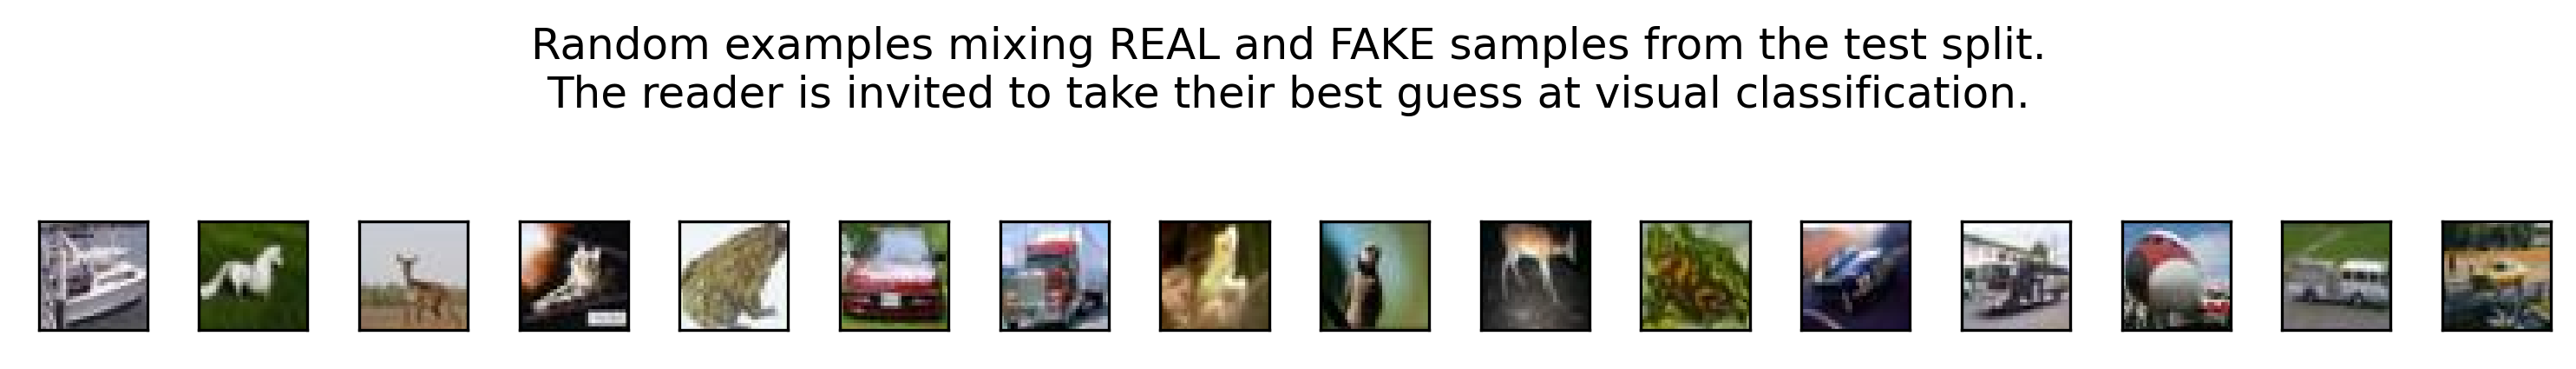

In [13]:
number_of_displayed_samples = 16

fig, ax = plt.subplots(1, number_of_displayed_samples)
fig.set_dpi(300)
fig.set_size_inches(10, 2, forward=True)

indices = np.random.randint(low=0, high=19999, size=number_of_displayed_samples)

for i in range(number_of_displayed_samples):

    axx = ax[i]
    fig.sca(axx)
    plt.imshow(img.imread(os.path.join(path_dataset_train_real, samples_list_train_real[indices[i]])))
    plt.ylabel('Train\nREAL') if index==0 else None

[axx.set_xticks([]) for axx in ax.ravel()]
[axx.set_yticks([]) for axx in ax.ravel()]
plt.tight_layout()
plt.suptitle('Random examples mixing REAL and FAKE samples from the test split.\nThe reader is invited to take their best guess at visual classification.')
plt.show()

# Helper functions 

In [ ]:
def plot_metrics(model_history, test_loss, test_recall, test_accuracy, test_precision, number_of_epochs):
    fig, ax = plt.subplots(2, 2)
    fig.set_dpi(300)
    fig.set_size_inches(12, 12, forward=True)

    metric_name = 'loss'
    axx = ax[0, 0]
    fig.sca(axx)
    plt.plot(model_history.history['{}'.format(metric_name)], label='{}'.format(metric_name))
    plt.plot(model_history.history['val_{}'.format(metric_name)], label='val_{}'.format(metric_name))
    plt.scatter(number_of_epochs -1, test_loss, color='darkgreen', label='test_{}'.format(metric_name))
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()

    metric_name = 'recall'
    axx = ax[0, 1]
    fig.sca(axx)
    plt.plot(model_history.history['{}'.format(metric_name)], label='{}'.format(metric_name))
    plt.plot(model_history.history['val_{}'.format(metric_name)], label='val_{}'.format(metric_name))
    plt.scatter(number_of_epochs -1, test_recall, color='darkgreen', label='test_{}'.format(metric_name))
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()

    metric_name = 'accuracy'
    axx = ax[1, 0]
    fig.sca(axx)
    plt.plot(model_history.history['{}'.format(metric_name)], label='{}'.format(metric_name))
    plt.plot(model_history.history['val_{}'.format(metric_name)], label='val_{}'.format(metric_name))
    plt.scatter(number_of_epochs -1, test_accuracy, color='darkgreen', label='test_{}'.format(metric_name))    
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    
    metric_name = 'precision'
    axx = ax[1, 1]
    fig.sca(axx)
    plt.plot(model_history.history['{}'.format(metric_name)], label='{}'.format(metric_name))
    plt.plot(model_history.history['val_{}'.format(metric_name)], label='val_{}'.format(metric_name))
    plt.scatter(number_of_epochs -1, test_precision, color='darkgreen', label='test_{}'.format(metric_name))    
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def evaluate_model(model, dataloader, split_name):
    loss, accuracy, precision, recall = model.evaluate(dataloader)
    print('Dataset: {}'.format(split_name))
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    return loss, accuracy, precision, recall

In [ ]:
def get_predictions_and_labels(dataloader, model):
    predicted_values = np.array([])
    predicted_classes = np.array([])
    labels = np.array([])    
    for x, y in dataloader:        
        predicted_values = np.concatenate([predicted_values, model(x)[:,0]])
        predicted_classes = np.concatenate([predicted_classes, [0 if pred < 0.5 else 1 for pred in model(x)]])
        labels = np.concatenate([labels, y])
    return predicted_values, predicted_classes, labels

In [ ]:
def plot_confusion_matrix(labels, predicted_classes, class_names):
    cm = confusion_matrix(labels, predicted_classes)
    plt.figure()
    fig.set_dpi(300)
    fig.set_size_inches(12, 12, forward=True)
    sns.heatmap(cm/np.sum(cm), annot=True, cmap='Blues',fmt='.2%', square=True, xticklabels=class_names, yticklabels=class_names, vmin=0, vmax=1)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_roc_curve(labels, predicted_values):
    fpr, tpr, thresholds = roc_curve(labels, predicted_values)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    fig.set_dpi(300)
    fig.set_size_inches(12, 12, forward=True)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='ROC AUC = {:.3f})'.format(roc_auc))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.tight_layout()    
    plt.gca().set_aspect('equal')
    plt.show()

In [ ]:
def plot_predicted_values_per_class(predicted_values, labels):
    plt.figure()
    fig.set_dpi(300)
    fig.set_size_inches(12, 12, forward=True)
    plt.plot(np.sort(predicted_values[labels==1]), label='Real images')
    plt.plot(np.flip(np.sort(predicted_values[labels==0])), label='Fake images')
    plt.xlabel('Samples (sorted)')
    plt.ylabel('Predicted values')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_extreme_predictions(predicted_values, labels):

    indices_of_real_images = np.where(labels==1)
    indices_of_fake_images = np.where(labels==0)

    predicted_value_for_real_images = predicted_values[labels==1]
    predicted_value_for_fake_images = predicted_values[labels==0]

    indices_of_real_images_sorted_from_worst_to_best_prediction = np.argsort(predicted_value_for_real_images)
    indices_of_fake_images_sorted_from_worst_to_best_prediction = np.flip(np.argsort(predicted_value_for_fake_images))
    
    # Display a few images
    number_of_displayed_samples = 16
    
    fig, ax = plt.subplots(4, number_of_displayed_samples)
    fig.set_dpi(300)
    fig.set_size_inches(10, 3, forward=True)
    
    for i in range(number_of_displayed_samples):
    
        axx = ax[0, i]
        fig.sca(axx)
        index = indices_of_real_images_sorted_from_worst_to_best_prediction[i]
        plt.imshow(img.imread(os.path.join(path_dataset_train_real, samples_list_train_real[index])))
        plt.ylabel('REAL\n(failures)') if i==0 else None
    
        axx = ax[1, i]
        fig.sca(axx)
        index = indices_of_real_images_sorted_from_worst_to_best_prediction[9999-i]        
        plt.imshow(img.imread(os.path.join(path_dataset_test_real, samples_list_test_real[index])))
        plt.ylabel('REAL\n(success)') if i==0 else None
    
        axx = ax[2, i]
        fig.sca(axx)
        index = indices_of_fake_images_sorted_from_worst_to_best_prediction[i]        
        plt.imshow(img.imread(os.path.join(path_dataset_train_fake, samples_list_train_fake[index])))
        plt.ylabel('FAKE\n(failures)') if i==0 else None
    
        axx = ax[3, i]
        fig.sca(axx)
        index = indices_of_fake_images_sorted_from_worst_to_best_prediction[9999-i]             
        plt.imshow(img.imread(os.path.join(path_dataset_test_fake, samples_list_test_fake[index])))
        plt.ylabel('FAKE\n(success)') if i==0 else None    
    
    [axx.set_xticks([]) for axx in ax.ravel()]
    [axx.set_yticks([]) for axx in ax.ravel()]
    plt.tight_layout()    
    plt.suptitle('Correctly (\'success\') and incorrectly (\'failures\') classified images')
    plt.show()

# Model 0 | Random predictions | ROC AUC 0.492

In [ ]:
# Generate random predictions
labels = np.array([])
for x, y in test_set_dataloader:
    labels = np.concatenate([labels, y])
    
predicted_values = np.random.rand(len(labels),)
predicted_values -= np.min(predicted_values)
predicted_values /= np.max(predicted_values)
predicted_classes = (predicted_values > 0.5).astype(np.int32)

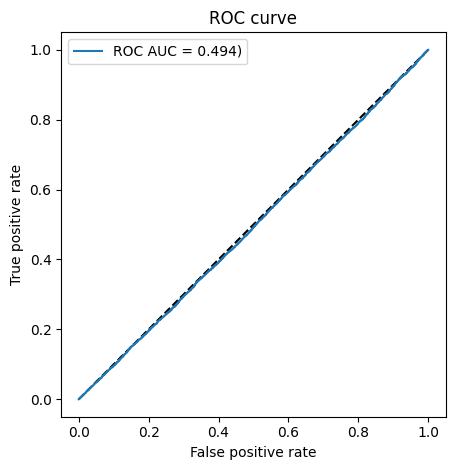

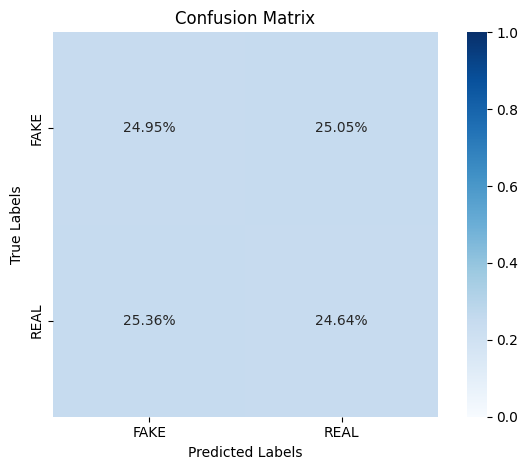

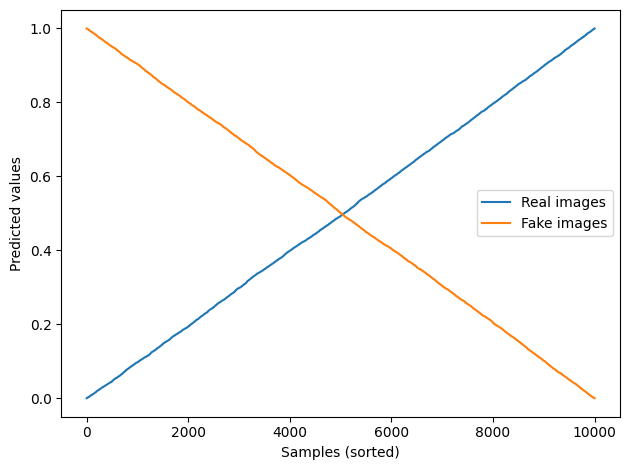

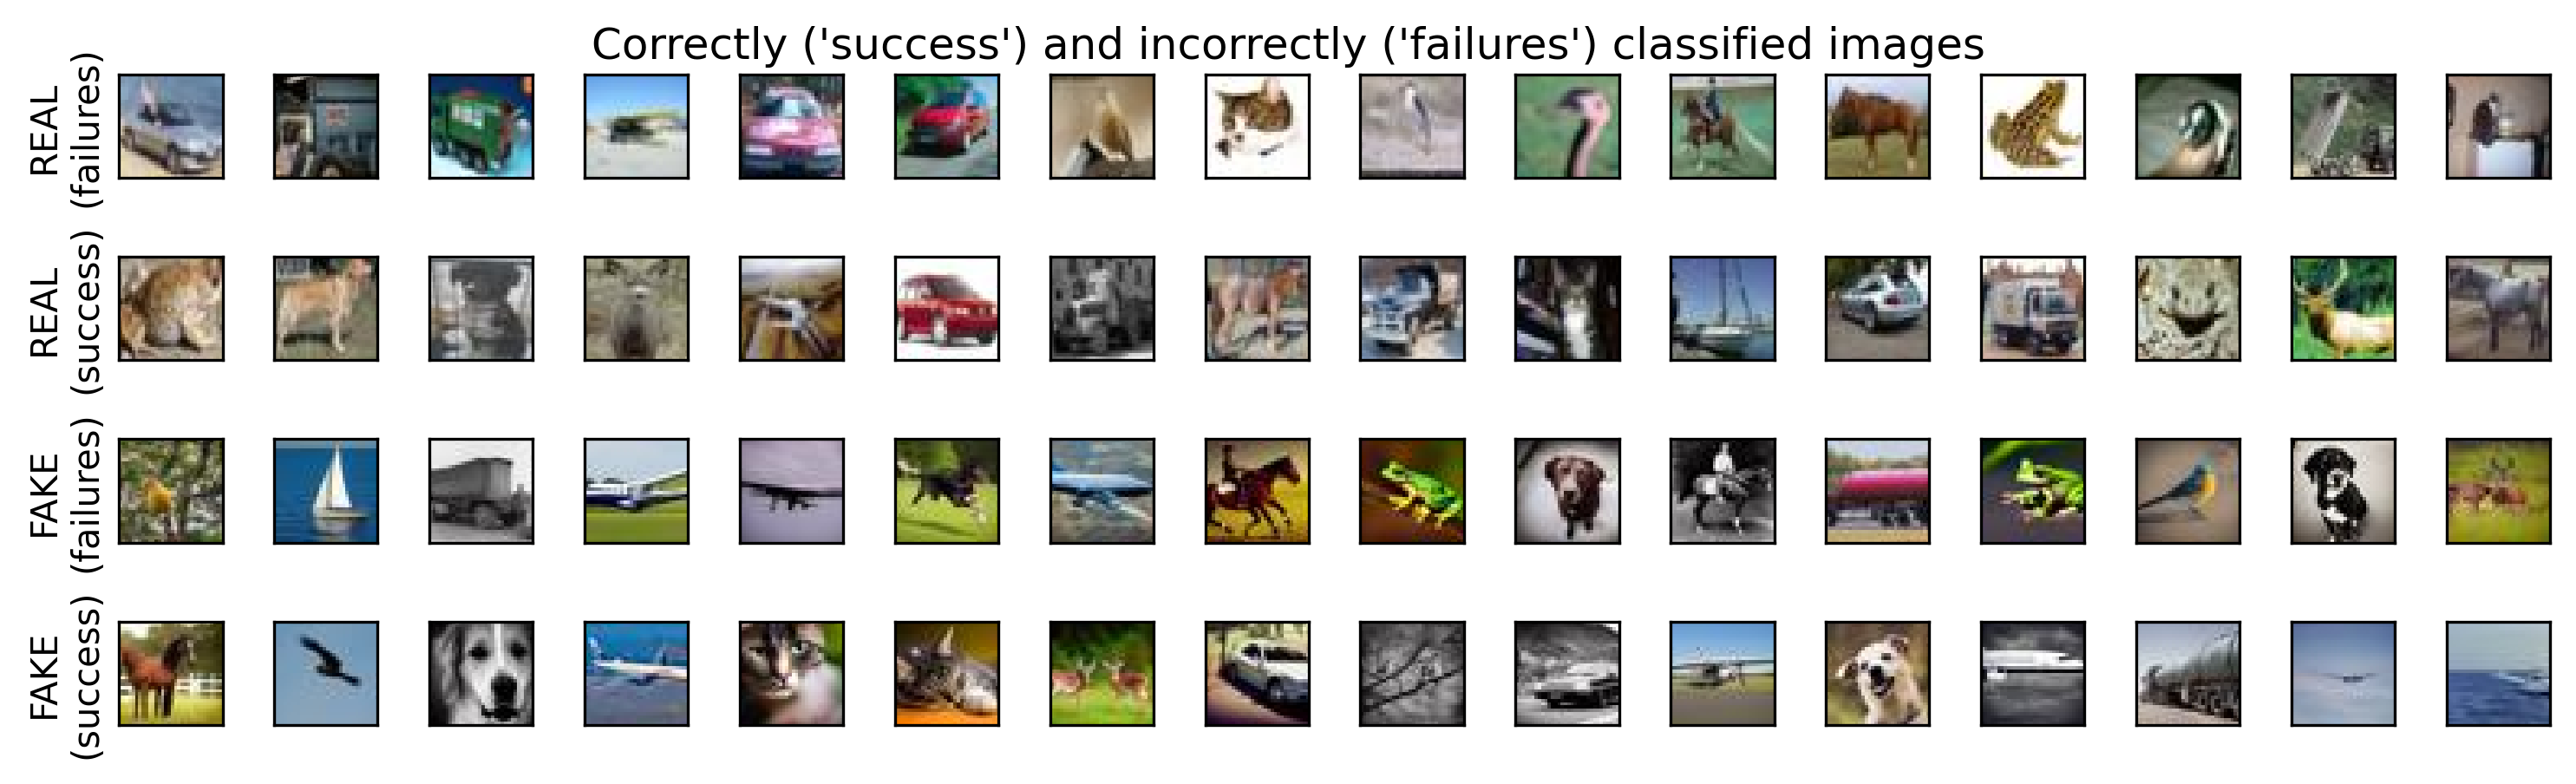

In [22]:
# Plot results
plot_roc_curve(labels, predicted_values)
plot_confusion_matrix(labels, predicted_classes, test_set_dataloader.class_names)
plot_predicted_values_per_class(predicted_values, labels)
plot_extreme_predictions(predicted_values, labels)

# Model 1 | Fully-convolutional | 2.3k parameters | ROC AUC 0.951

In [23]:
# Design the model
model = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal', seed=random_seed),
    tf.keras.layers.Resizing(image_height, image_width),
    tf.keras.layers.Rescaling(scale=1./127.5, offset=-1),    
    tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation='sigmoid')])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall')])

# Build the model and show the summary
model.build(input_shape=(None, image_height, image_width, 3))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,305 (9.00 KB)

 Trainable params: 2,289 (8.94 KB)

 Non-trainable params: 16 (64.00 B)

In [ ]:
# Train the model
number_of_epochs = 50
history = model.fit(
    train_set_dataloader, validation_data=validation_set_dataloader, epochs=number_of_epochs, verbose=2)

In [ ]:
# Infer the model
evaluate_model(model, validation_set_dataloader, 'Validation')
test_loss, test_accuracy, test_precision, test_recall = evaluate_model(model, test_set_dataloader, 'Test')
predicted_values, predicted_classes, labels = get_predictions_and_labels(test_set_dataloader, model)

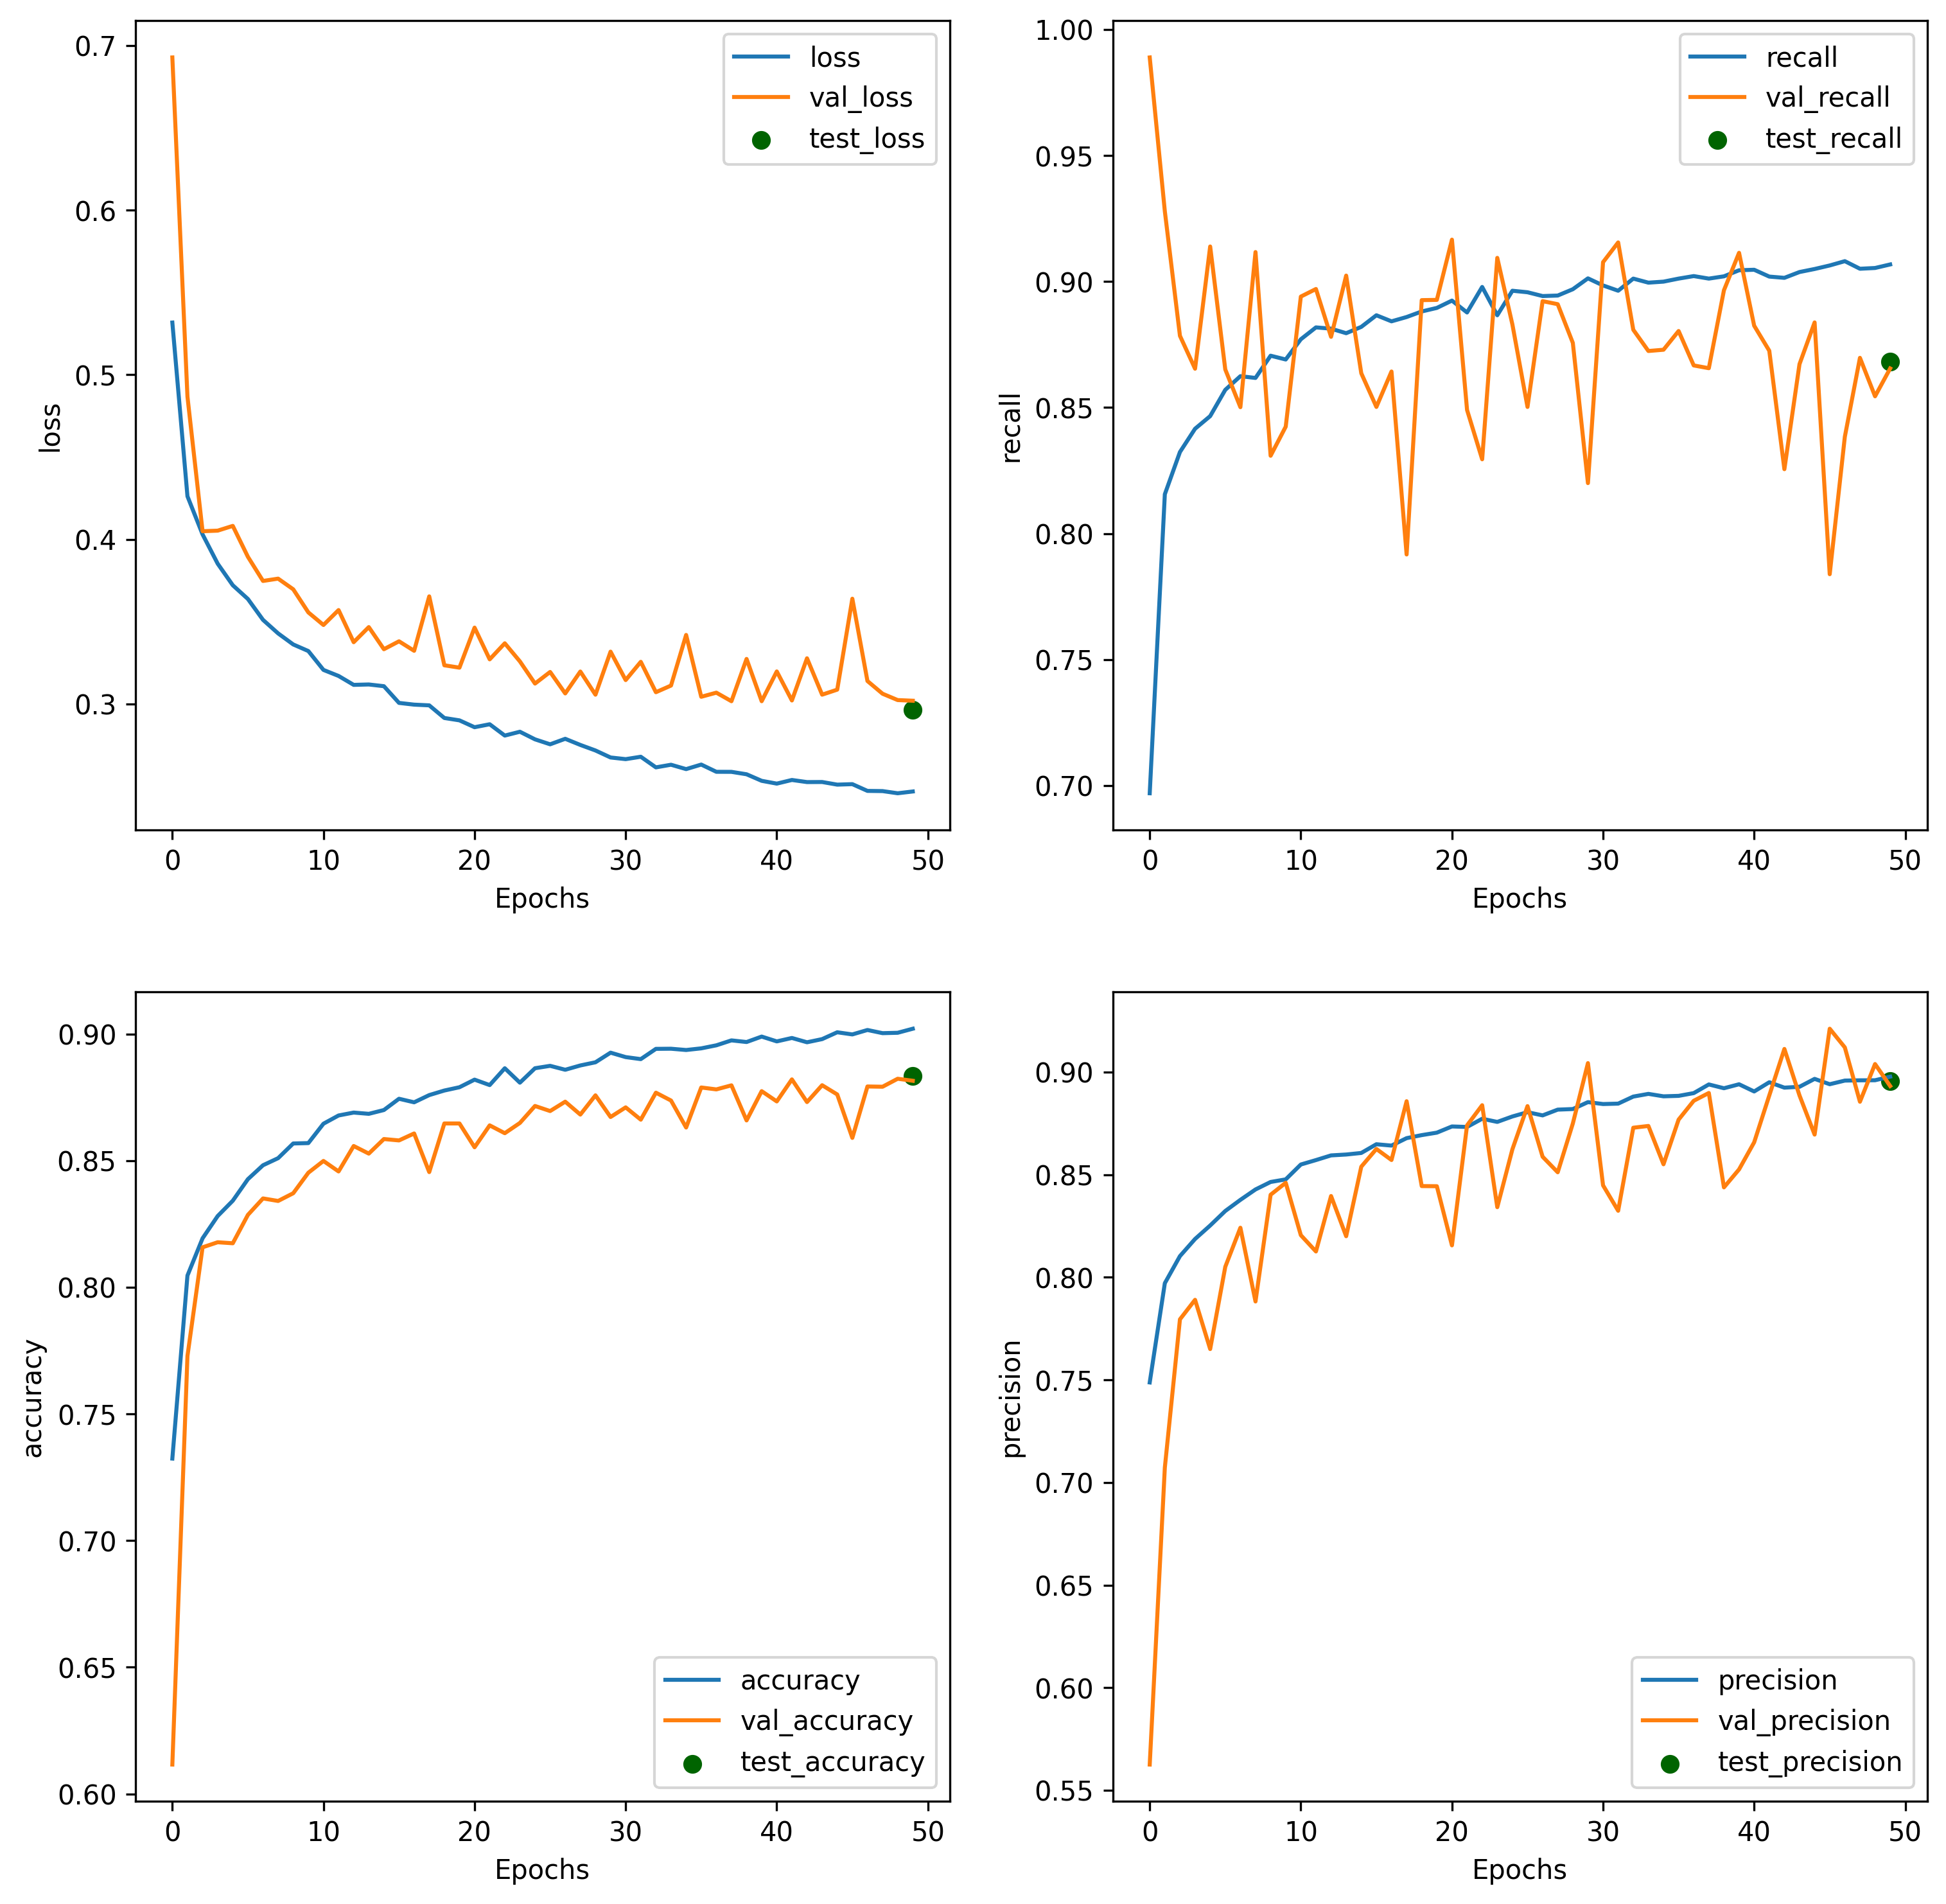

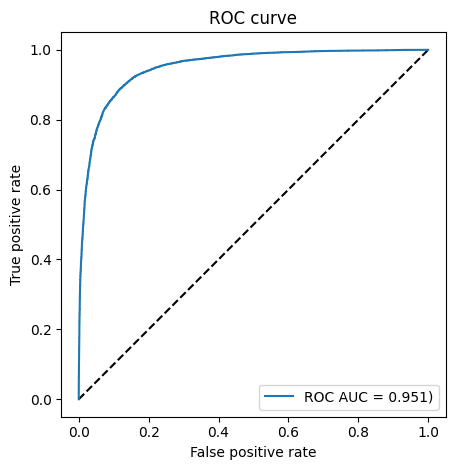

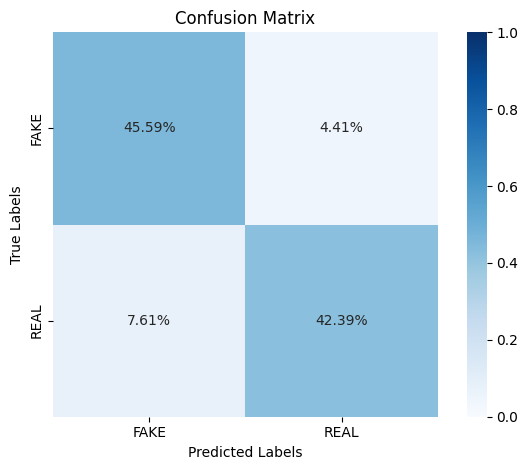

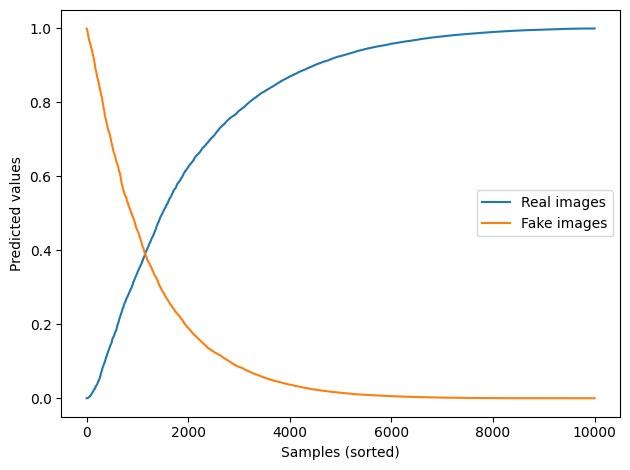

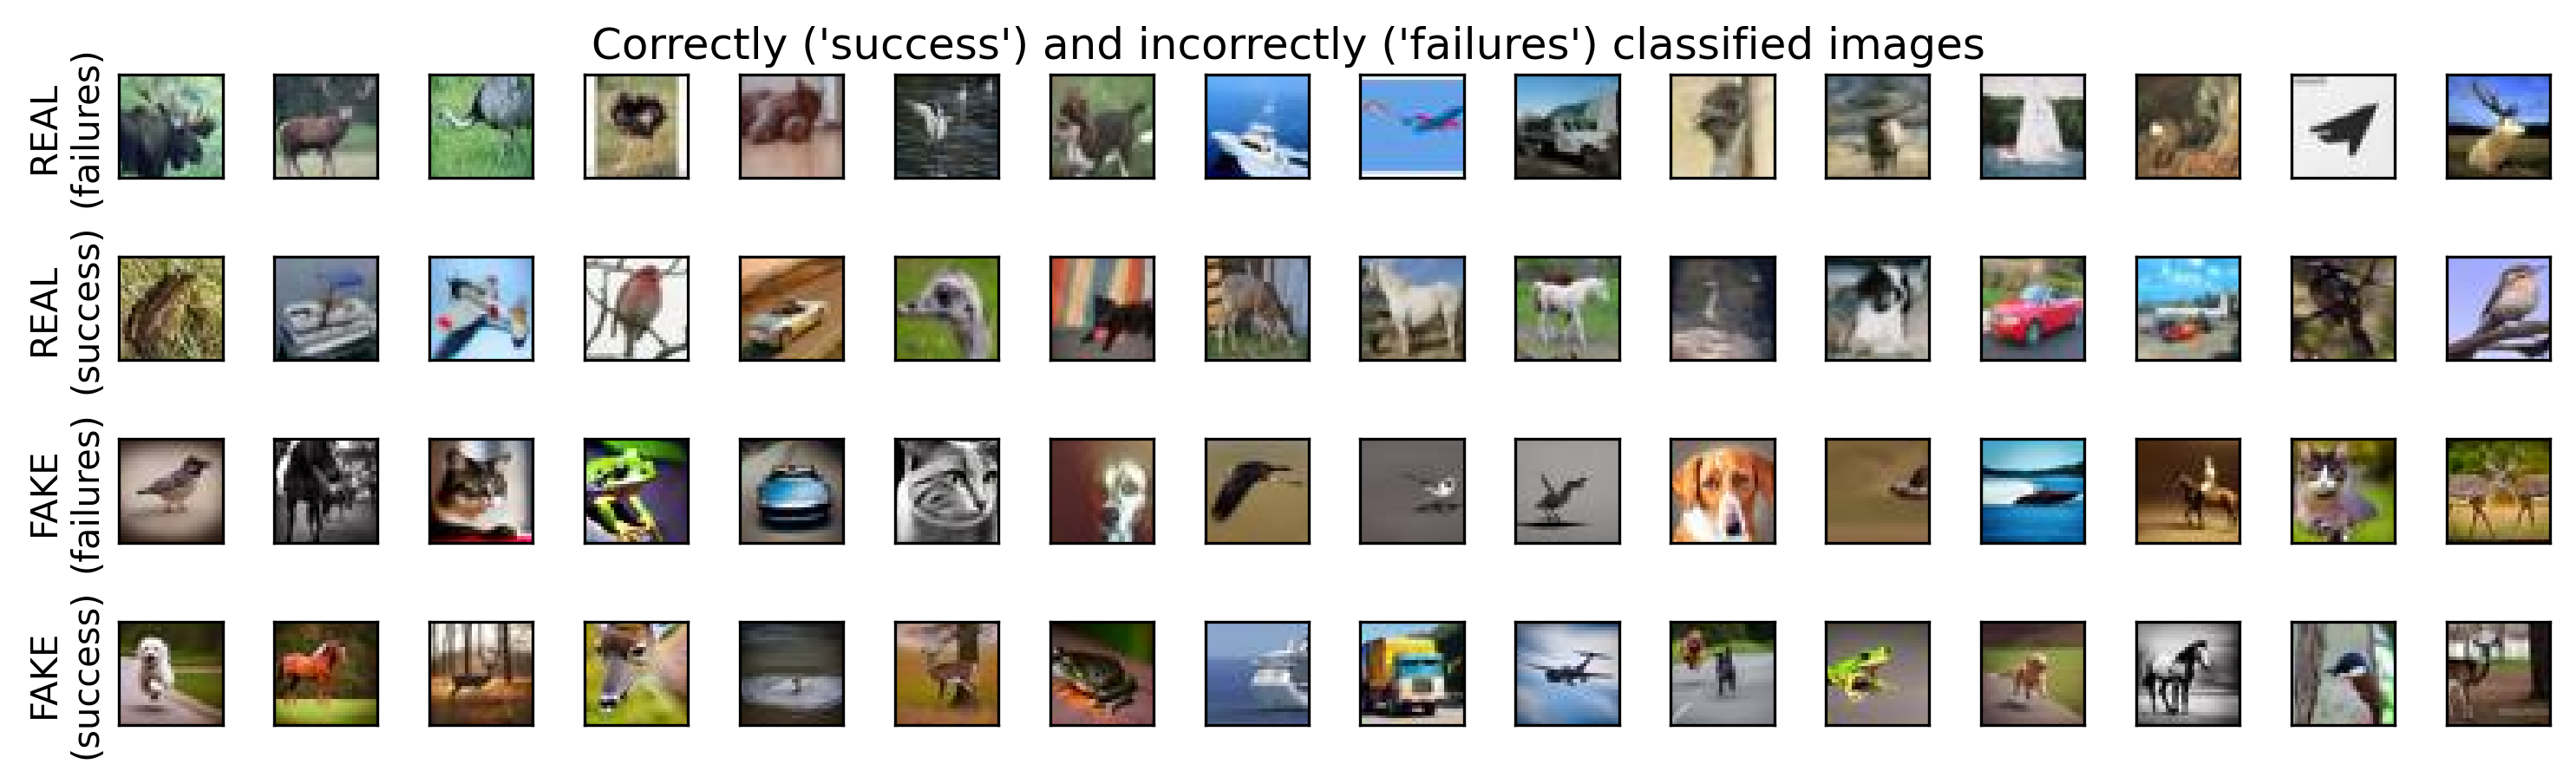

In [26]:
# Plot results
plot_metrics(history, test_loss, test_recall, test_accuracy, test_precision, number_of_epochs)
plot_roc_curve(labels, predicted_values)
plot_confusion_matrix(labels, predicted_classes, test_set_dataloader.class_names)
plot_predicted_values_per_class(predicted_values, labels)
plot_extreme_predictions(predicted_values, labels)

# Model 2 | Fully-convolutional | 1.2M parameters | ROC AUC 0.989

In [27]:
# Design the model
model = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal', seed=random_seed),
    tf.keras.layers.Resizing(image_height, image_width),
    tf.keras.layers.Rescaling(scale=1./127.5, offset=-1),    
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5), # Random dropout to prevent overfitting
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.5), # Random dropout to prevent overfitting
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.5), # Random dropout to prevent overfitting
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.5), # Random dropout to prevent overfitting
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.5), # Random dropout to prevent overfitting
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D(),    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation='sigmoid')])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall')])

# Build the model and show the summary
model.build(input_shape=(None, image_height, image_width, 3))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_1 (Resizing)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 1,153,089 (4.40 MB)

 Trainable params: 1,151,297 (4.39 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:
# Train the model
number_of_epochs = 50
history = model.fit(
    train_set_dataloader, validation_data=validation_set_dataloader, epochs=number_of_epochs, verbose=2)

In [ ]:
# Infer the model
evaluate_model(model, validation_set_dataloader, 'Validation')
test_loss, test_accuracy, test_precision, test_recall = evaluate_model(model, test_set_dataloader, 'Test')
predicted_values, predicted_classes, labels = get_predictions_and_labels(test_set_dataloader, model)

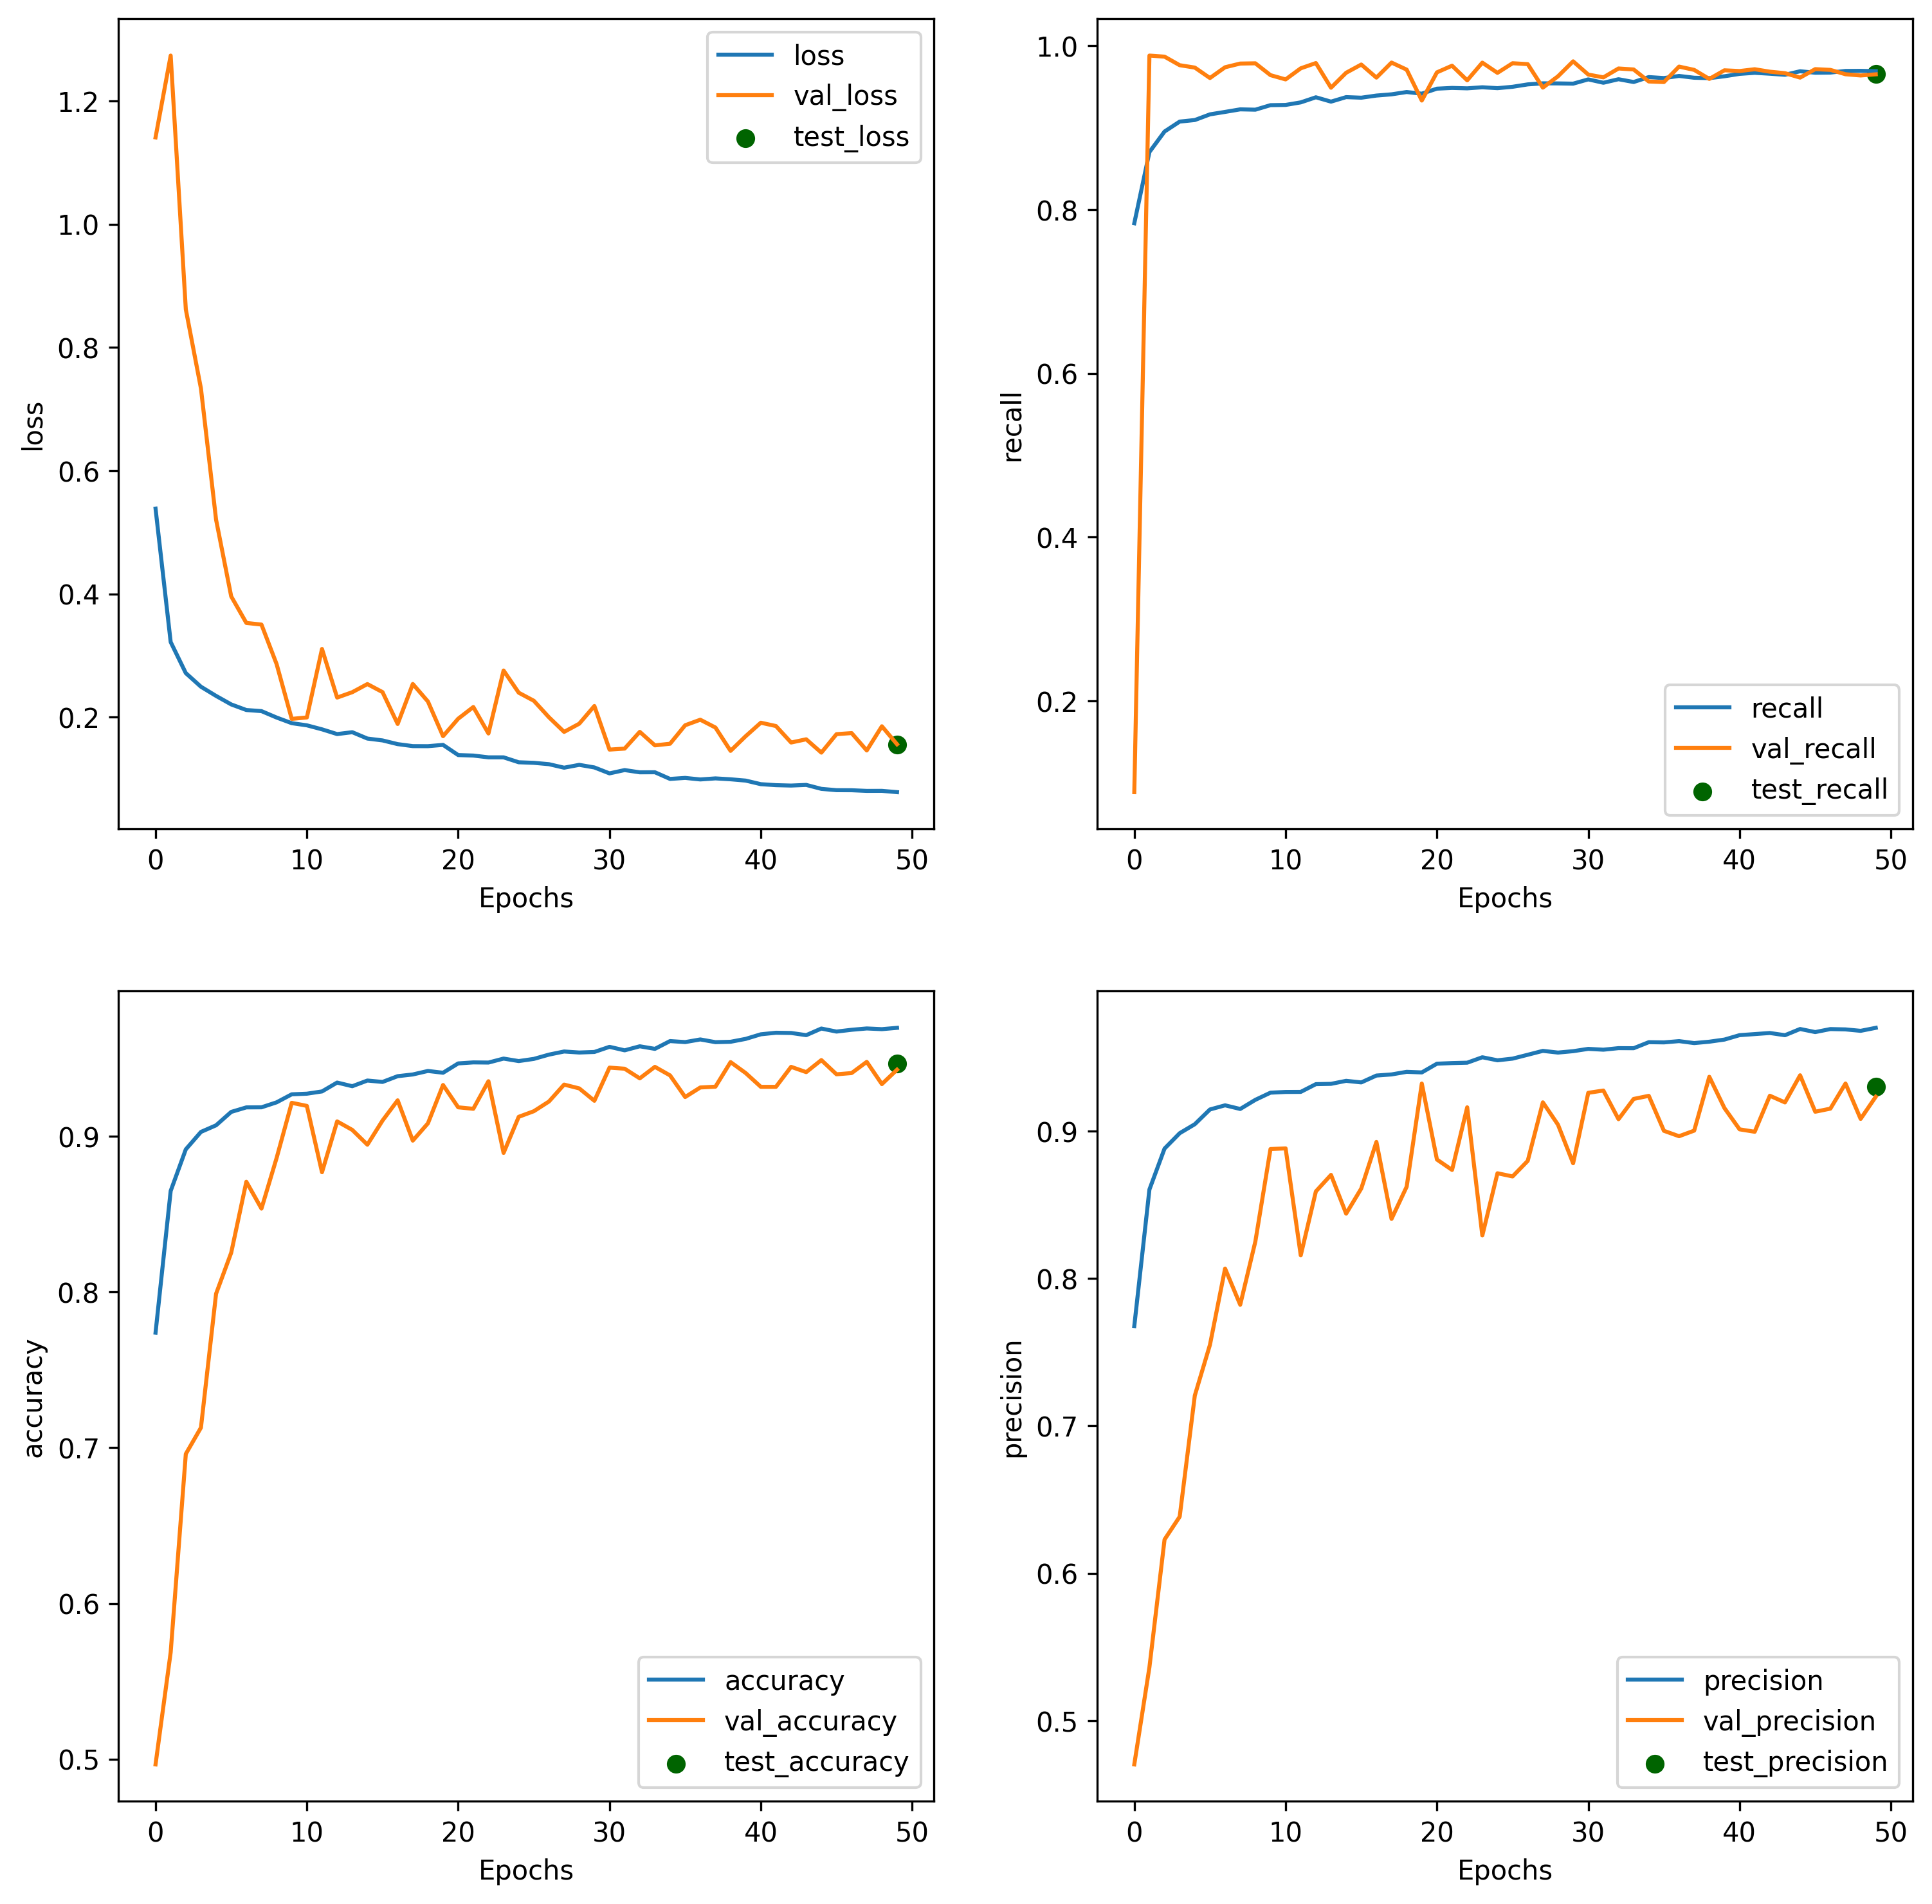

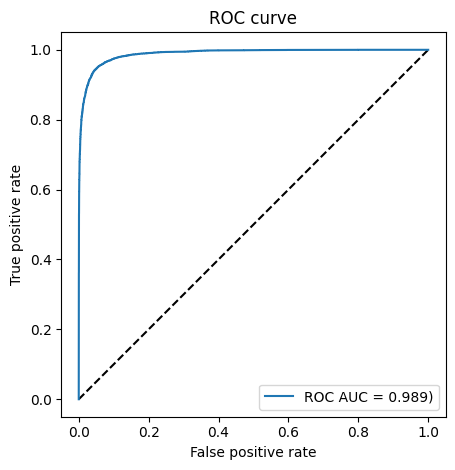

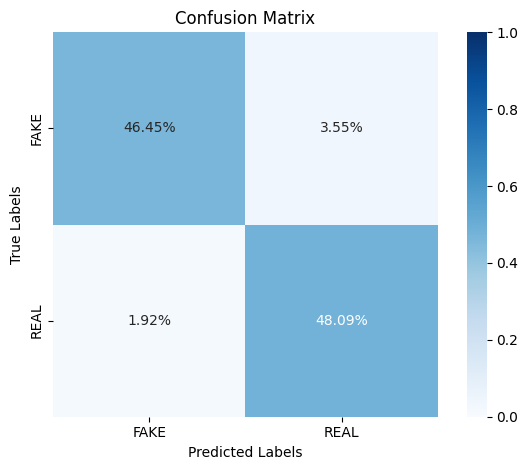

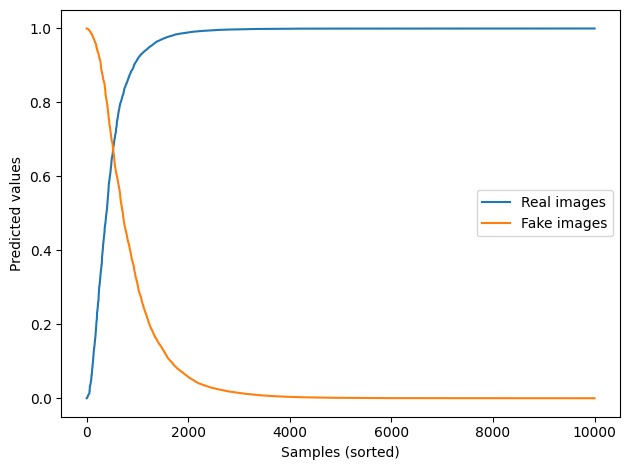

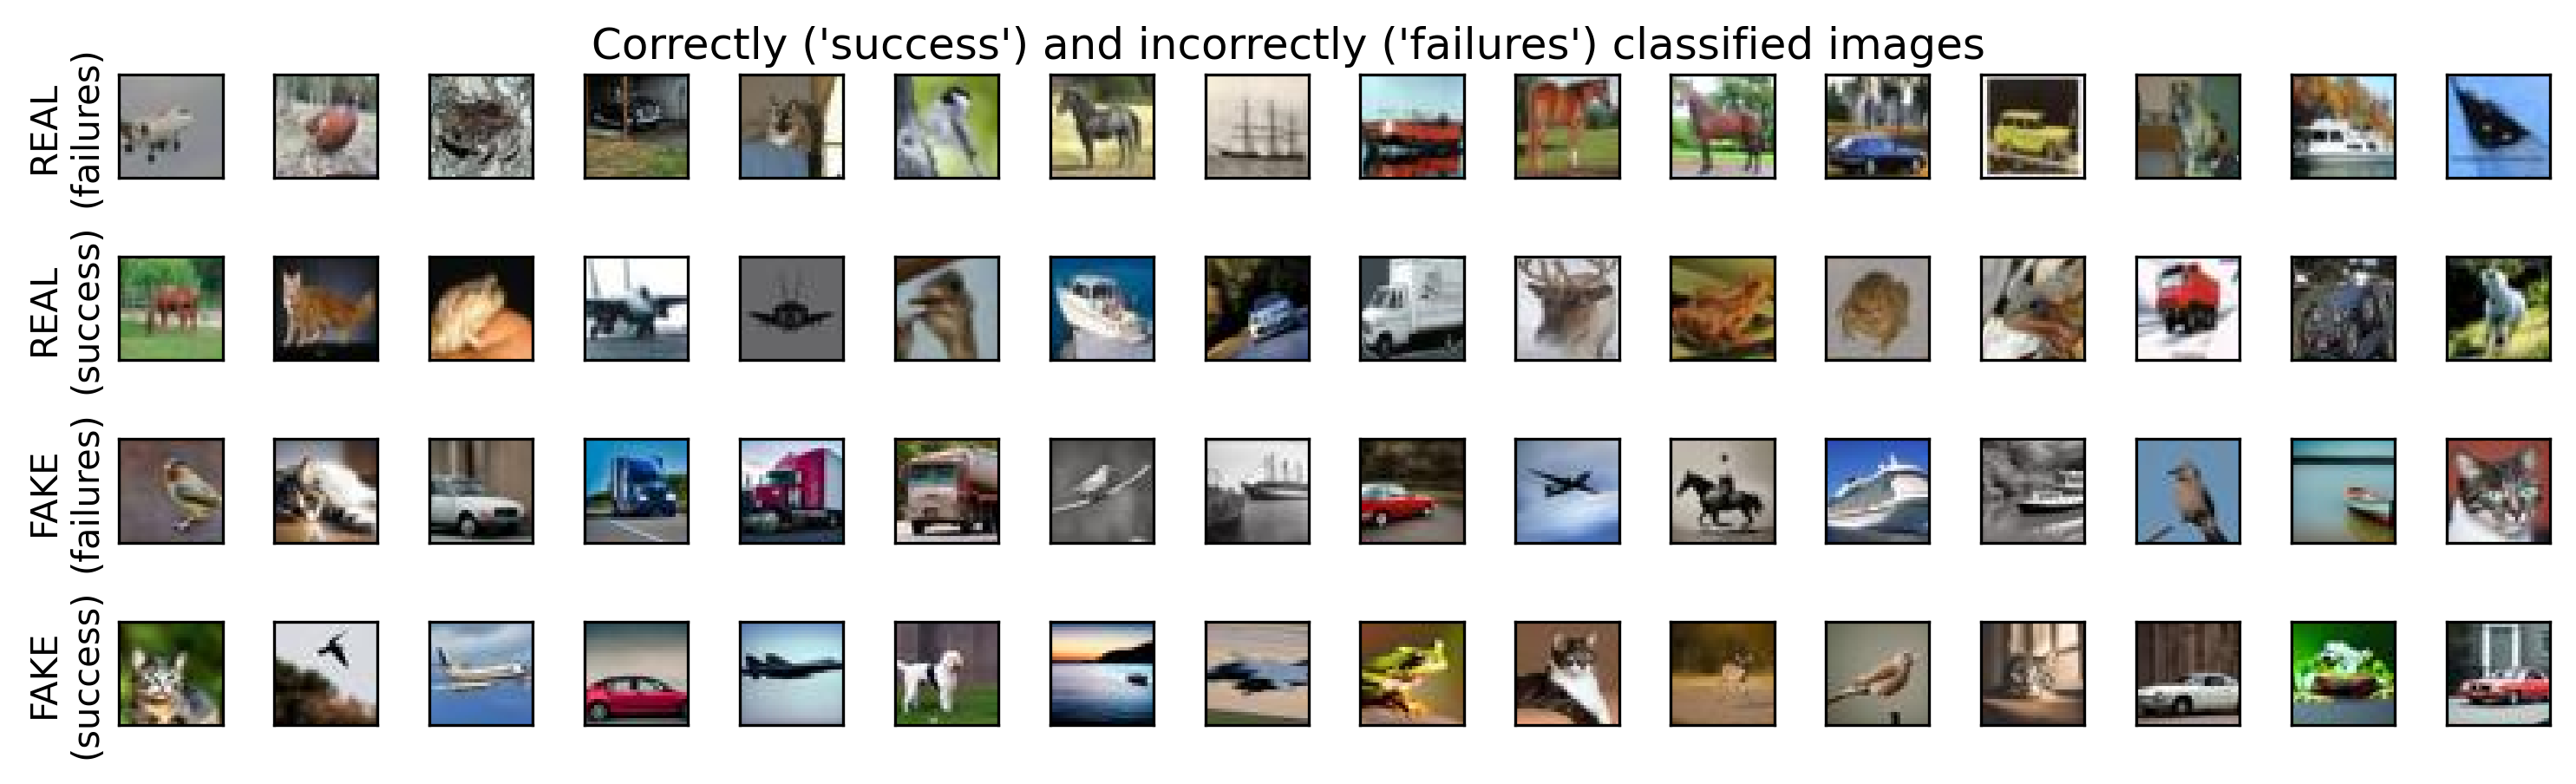

In [30]:
# Plot results
plot_metrics(history, test_loss, test_recall, test_accuracy, test_precision, number_of_epochs)
plot_roc_curve(labels, predicted_values)
plot_confusion_matrix(labels, predicted_classes, test_set_dataloader.class_names)
plot_predicted_values_per_class(predicted_values, labels)
plot_extreme_predictions(predicted_values, labels)

# Model 3 | Mostly dense connections | 2.1M parameters | ROC AUC 0.973

In [31]:
# Design the model
model = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal', seed=random_seed),
    tf.keras.layers.Resizing(image_height, image_width),
    tf.keras.layers.Rescaling(scale=1./127.5, offset=-1),    
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),    
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.MaxPooling2D(),    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='sigmoid'),
    tf.keras.layers.Dropout(0.5), # Random dropout to prevent overfitting
    tf.keras.layers.Dense(units=1, activation='sigmoid')])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall')])

# Build the model and show the summary
model.build(input_shape=(None, image_height, image_width, 3))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_2 (RandomFlip)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_2 (Resizing)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,099,457 (8.01 MB)

 Trainable params: 2,099,329 (8.01 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
# Train the model
number_of_epochs = 50
history = model.fit(
    train_set_dataloader, validation_data=validation_set_dataloader, epochs=number_of_epochs, verbose=2)

In [ ]:
# Infer the model
evaluate_model(model, validation_set_dataloader, 'Validation')
test_loss, test_accuracy, test_precision, test_recall = evaluate_model(model, test_set_dataloader, 'Test')
predicted_values, predicted_classes, labels = get_predictions_and_labels(test_set_dataloader, model)

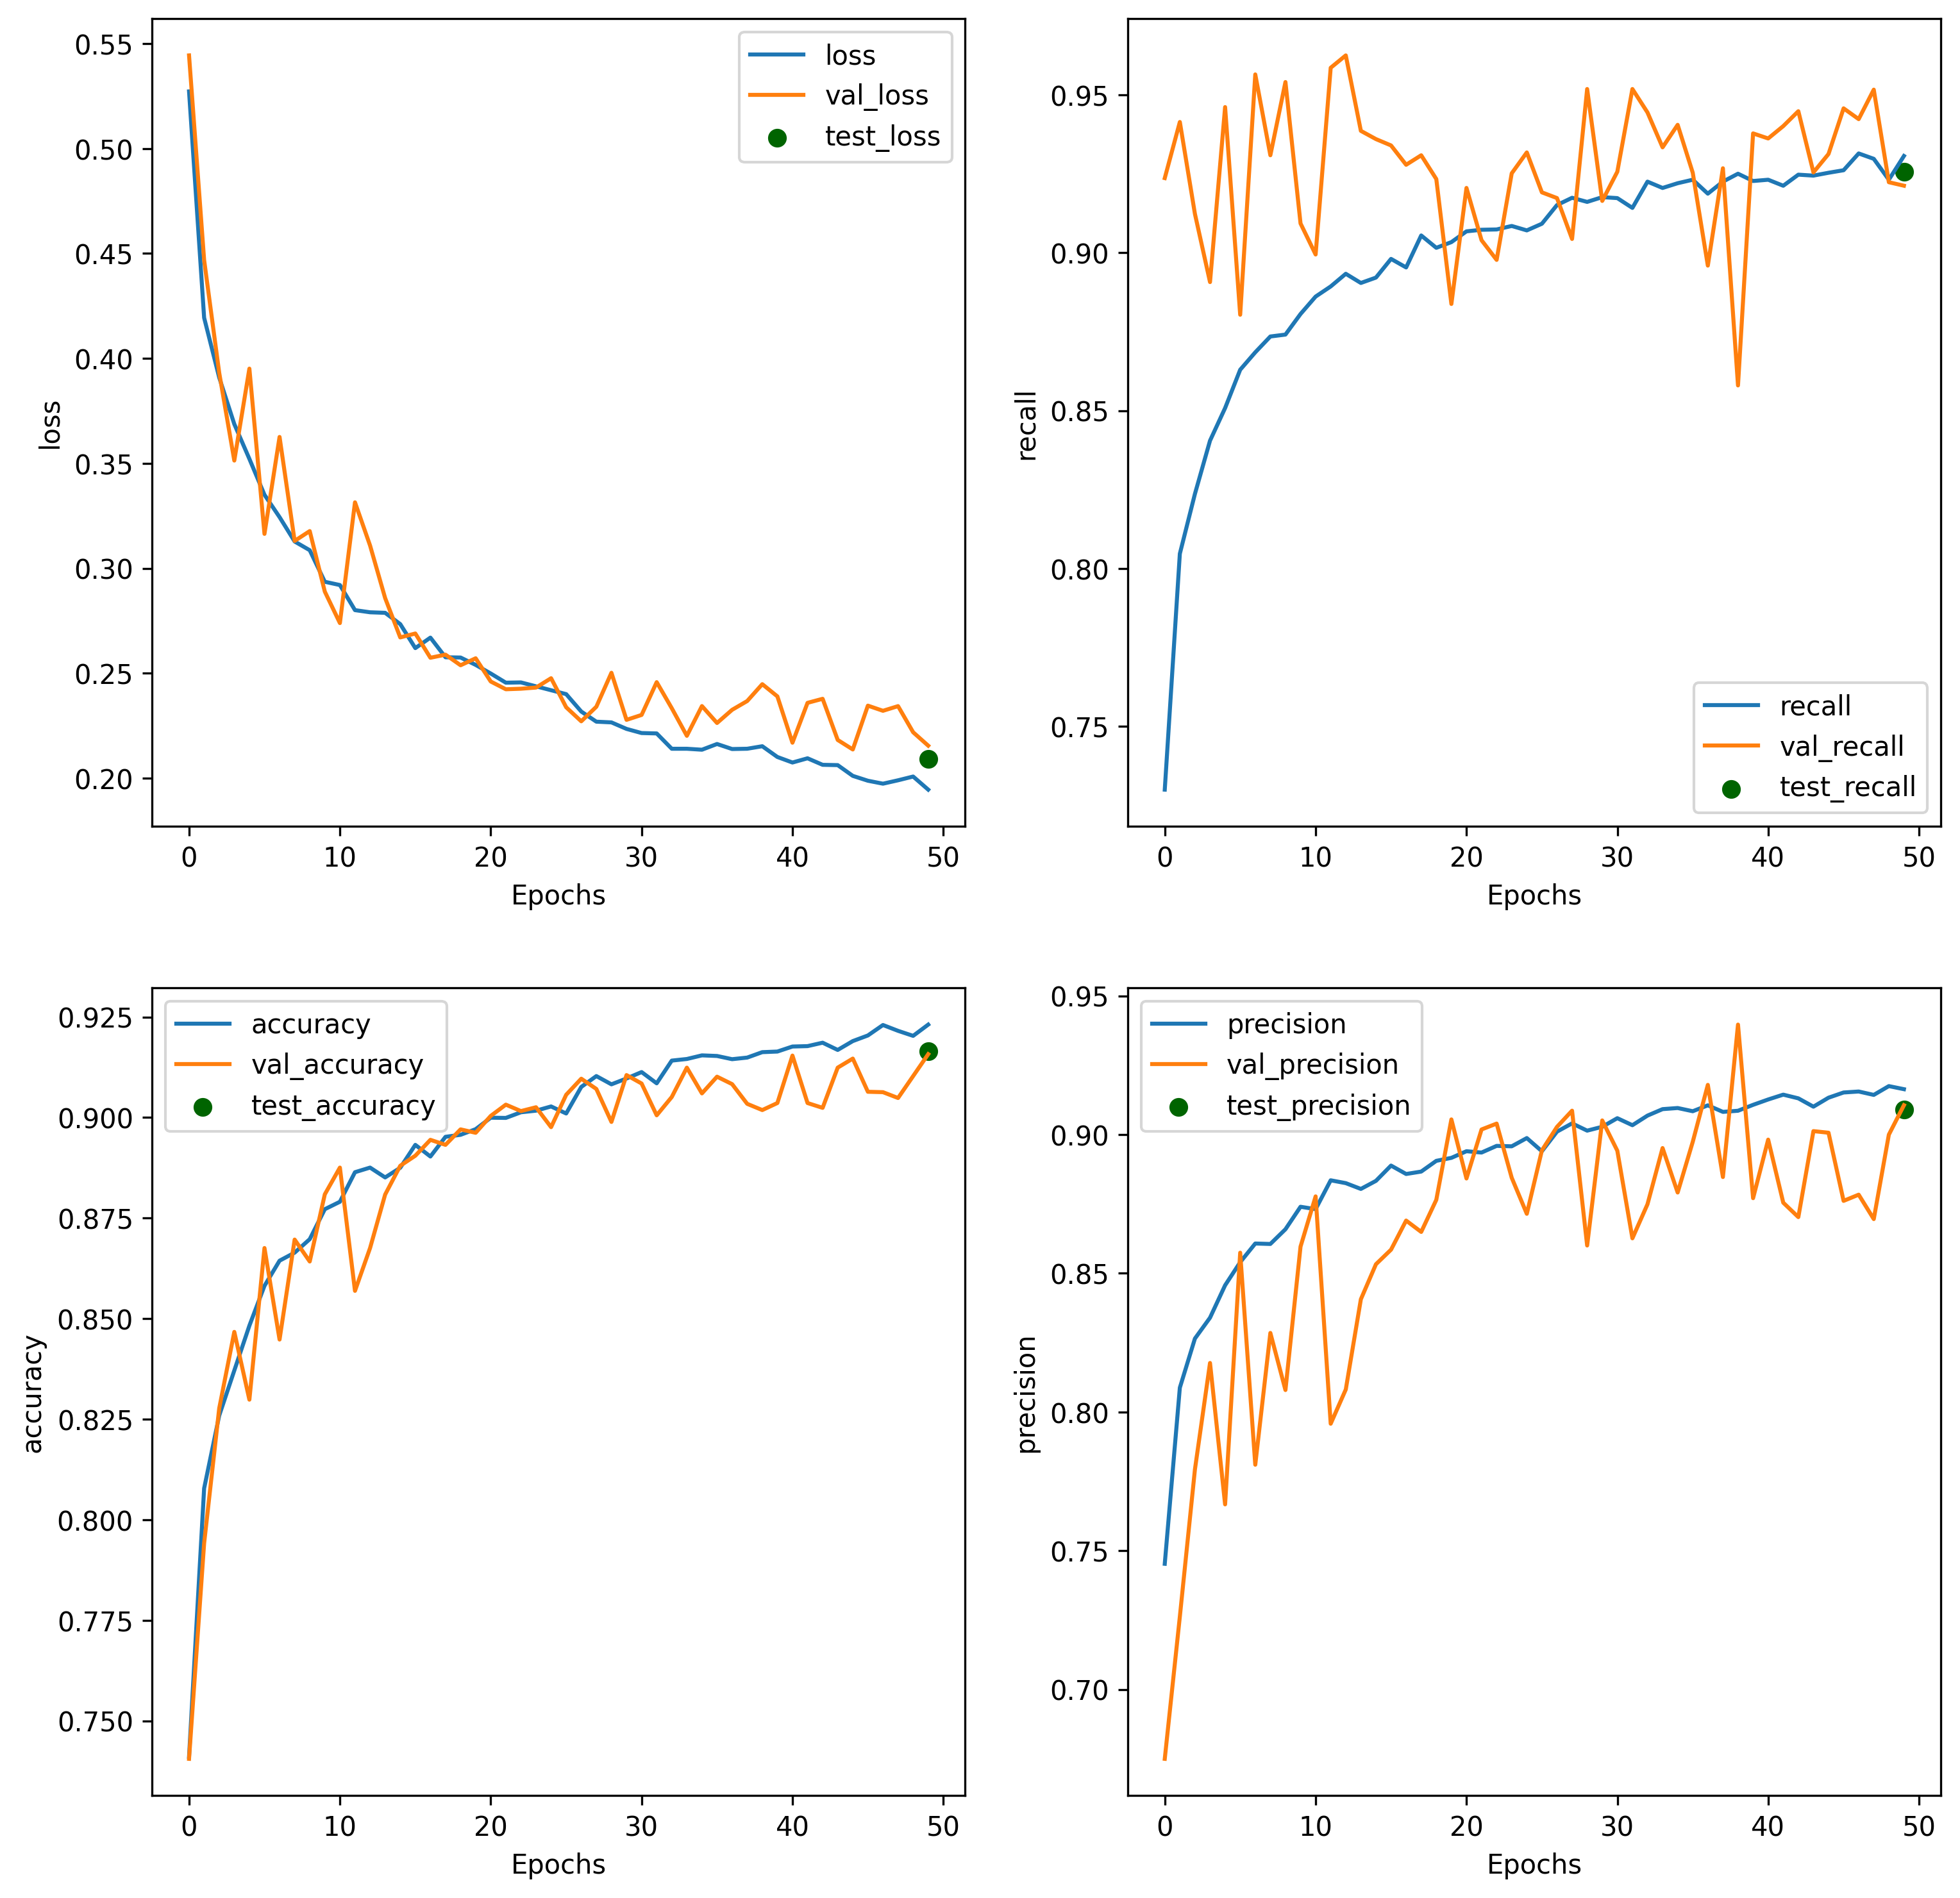

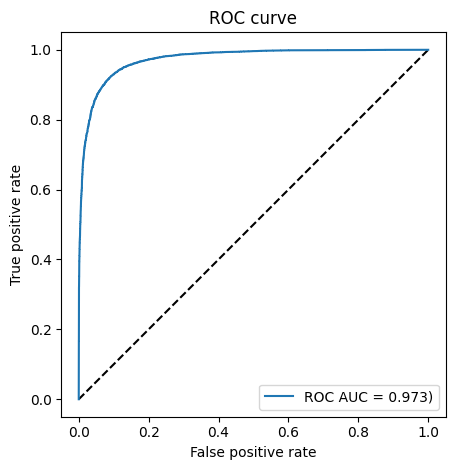

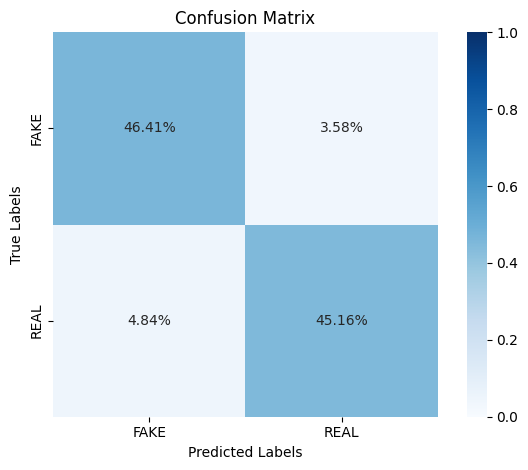

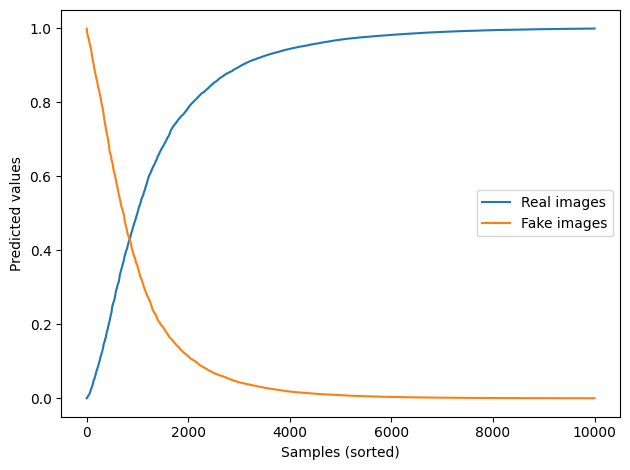

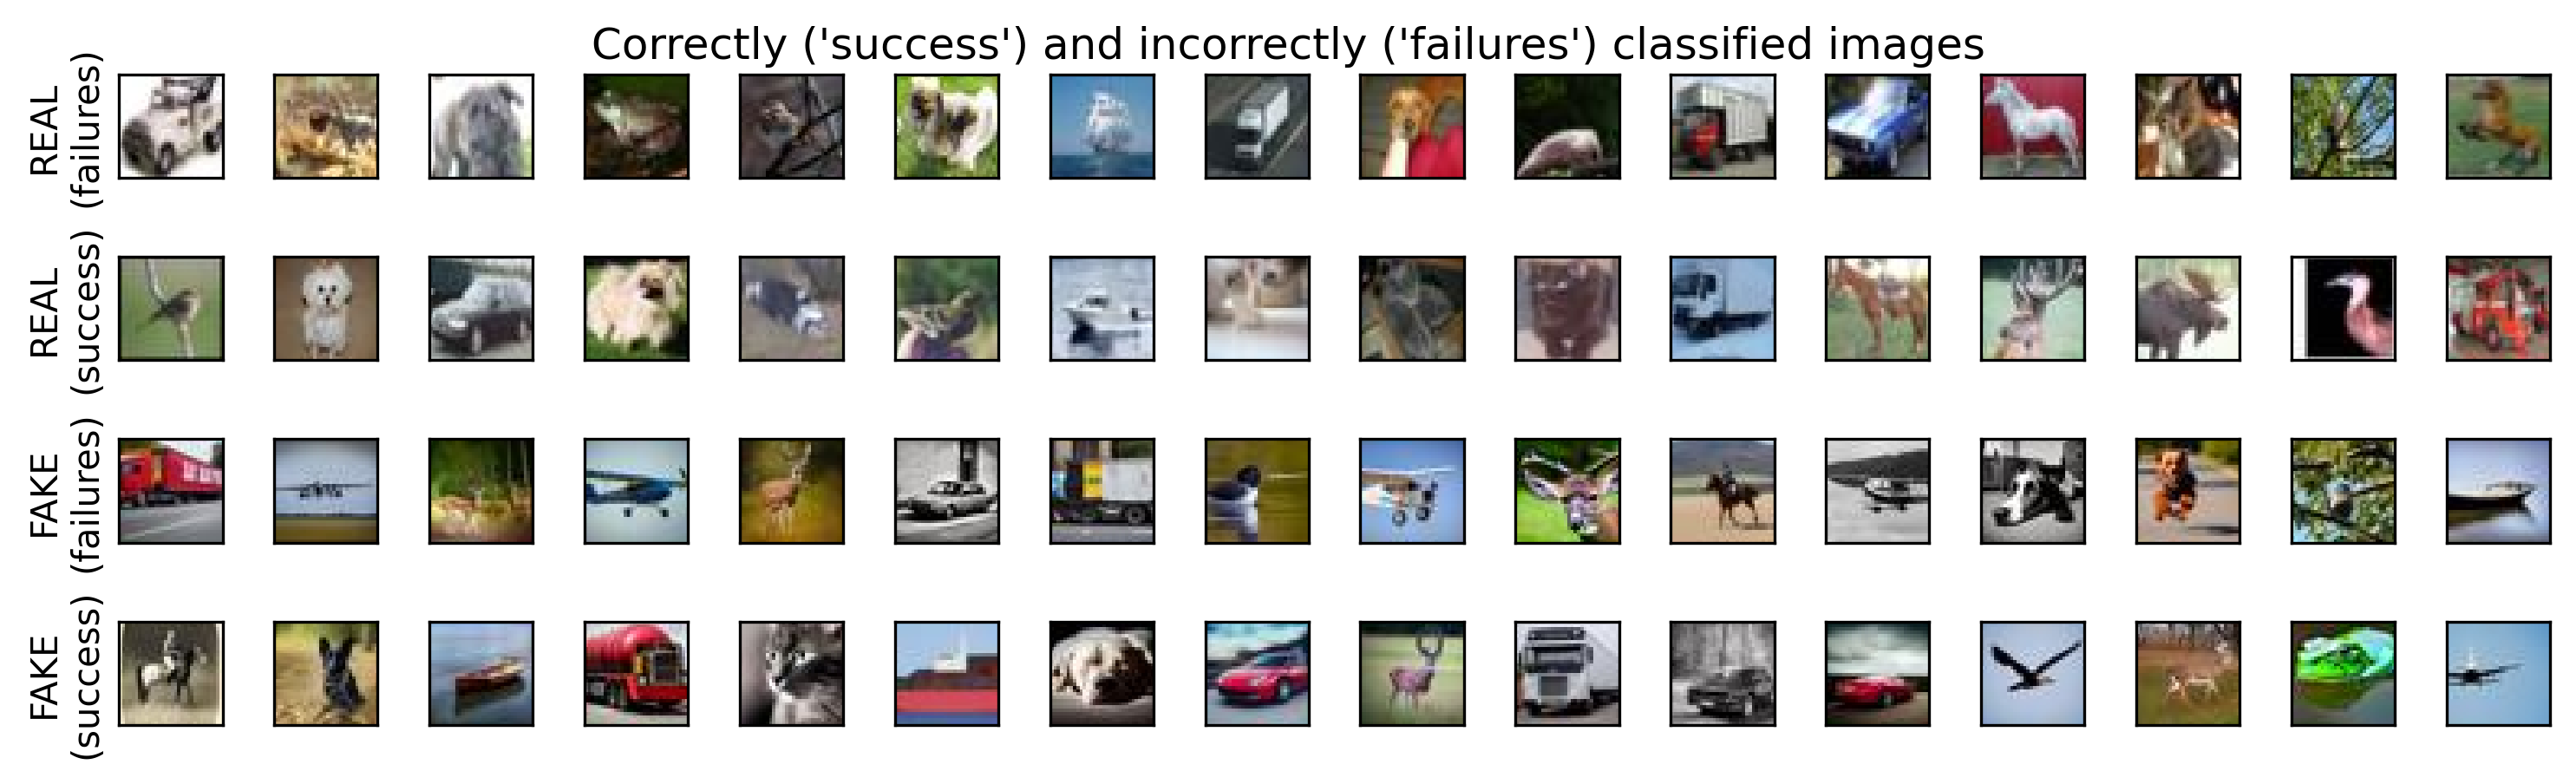

In [34]:
# Plot results
plot_metrics(history, test_loss, test_recall, test_accuracy, test_precision, number_of_epochs)
plot_roc_curve(labels, predicted_values)
plot_confusion_matrix(labels, predicted_classes, test_set_dataloader.class_names)
plot_predicted_values_per_class(predicted_values, labels)
plot_extreme_predictions(predicted_values, labels)

# Model 4 | U-Net Xception-style | 2.3M parameters | ROC AUC 0.973

In [ ]:
"""
Credits: François Chollet
Adapted from: https://keras.io/examples/vision/oxford_pets_image_segmentation/
"""

def get_xception_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("silu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for num_filters in [64, 128, 256]:
        x = tf.keras.layers.Activation("silu")(x)        
        x = tf.keras.layers.SeparableConv2D(filters=num_filters, kernel_size=3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("silu")(x)        
        x = tf.keras.layers.SeparableConv2D(filters=num_filters, kernel_size=3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for num_filters in [256, 128, 64, 32]:
        x = tf.keras.layers.Activation("silu")(x)        
        x = tf.keras.layers.Conv2DTranspose(filters=num_filters, kernel_size=3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("silu")(x)    
        x = tf.keras.layers.Conv2DTranspose(filters=num_filters, kernel_size=3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.UpSampling2D(2)(x)

        # Project residual
        residual = tf.keras.layers.UpSampling2D(2)(previous_block_activation)
        residual = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=1, padding="same")(residual)
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = tf.keras.layers.Conv2D(filters=1, kernel_size=3, activation="silu", padding="same")(x)
    outputs = tf.keras.layers.BatchNormalization()(outputs)    
    outputs = keras.layers.Flatten()(outputs)
    outputs = tf.keras.layers.Dense(units=256, activation='sigmoid')(outputs)
    outputs = tf.keras.layers.Dropout(0.5)(outputs) # Random dropout to prevent overfitting    
    outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(outputs)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [36]:
# Build and compile the model, and show the summary
model = get_xception_model(img_size=(image_height, image_width), num_classes=2)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall')])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │        896 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        128 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 16, 16,    │          0 │ activation[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 16, 16,    │      2,400 │ activation_1[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 16, 16,    │      4,736 │ activation_2[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 64)  │      2,112 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 8, 8, 64)  │          0 │ max_pooling2d_5[… │
│                     │                   │            │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 8, 8, 64)  │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 8, 8, 128) │      8,896 │ activation_3[0][… │
│ (SeparableConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                 

 Total params: 2,321,062 (8.85 MB)

 Trainable params: 2,317,284 (8.84 MB)

 Non-trainable params: 3,778 (14.76 KB)

In [ ]:
# Train the model
number_of_epochs = 50
history = model.fit(
    train_set_dataloader, validation_data=validation_set_dataloader, epochs=number_of_epochs, verbose=2)

In [ ]:
# Infer the model
evaluate_model(model, validation_set_dataloader, 'Validation')
test_loss, test_accuracy, test_precision, test_recall = evaluate_model(model, test_set_dataloader, 'Test')
predicted_values, predicted_classes, labels = get_predictions_and_labels(test_set_dataloader, model)

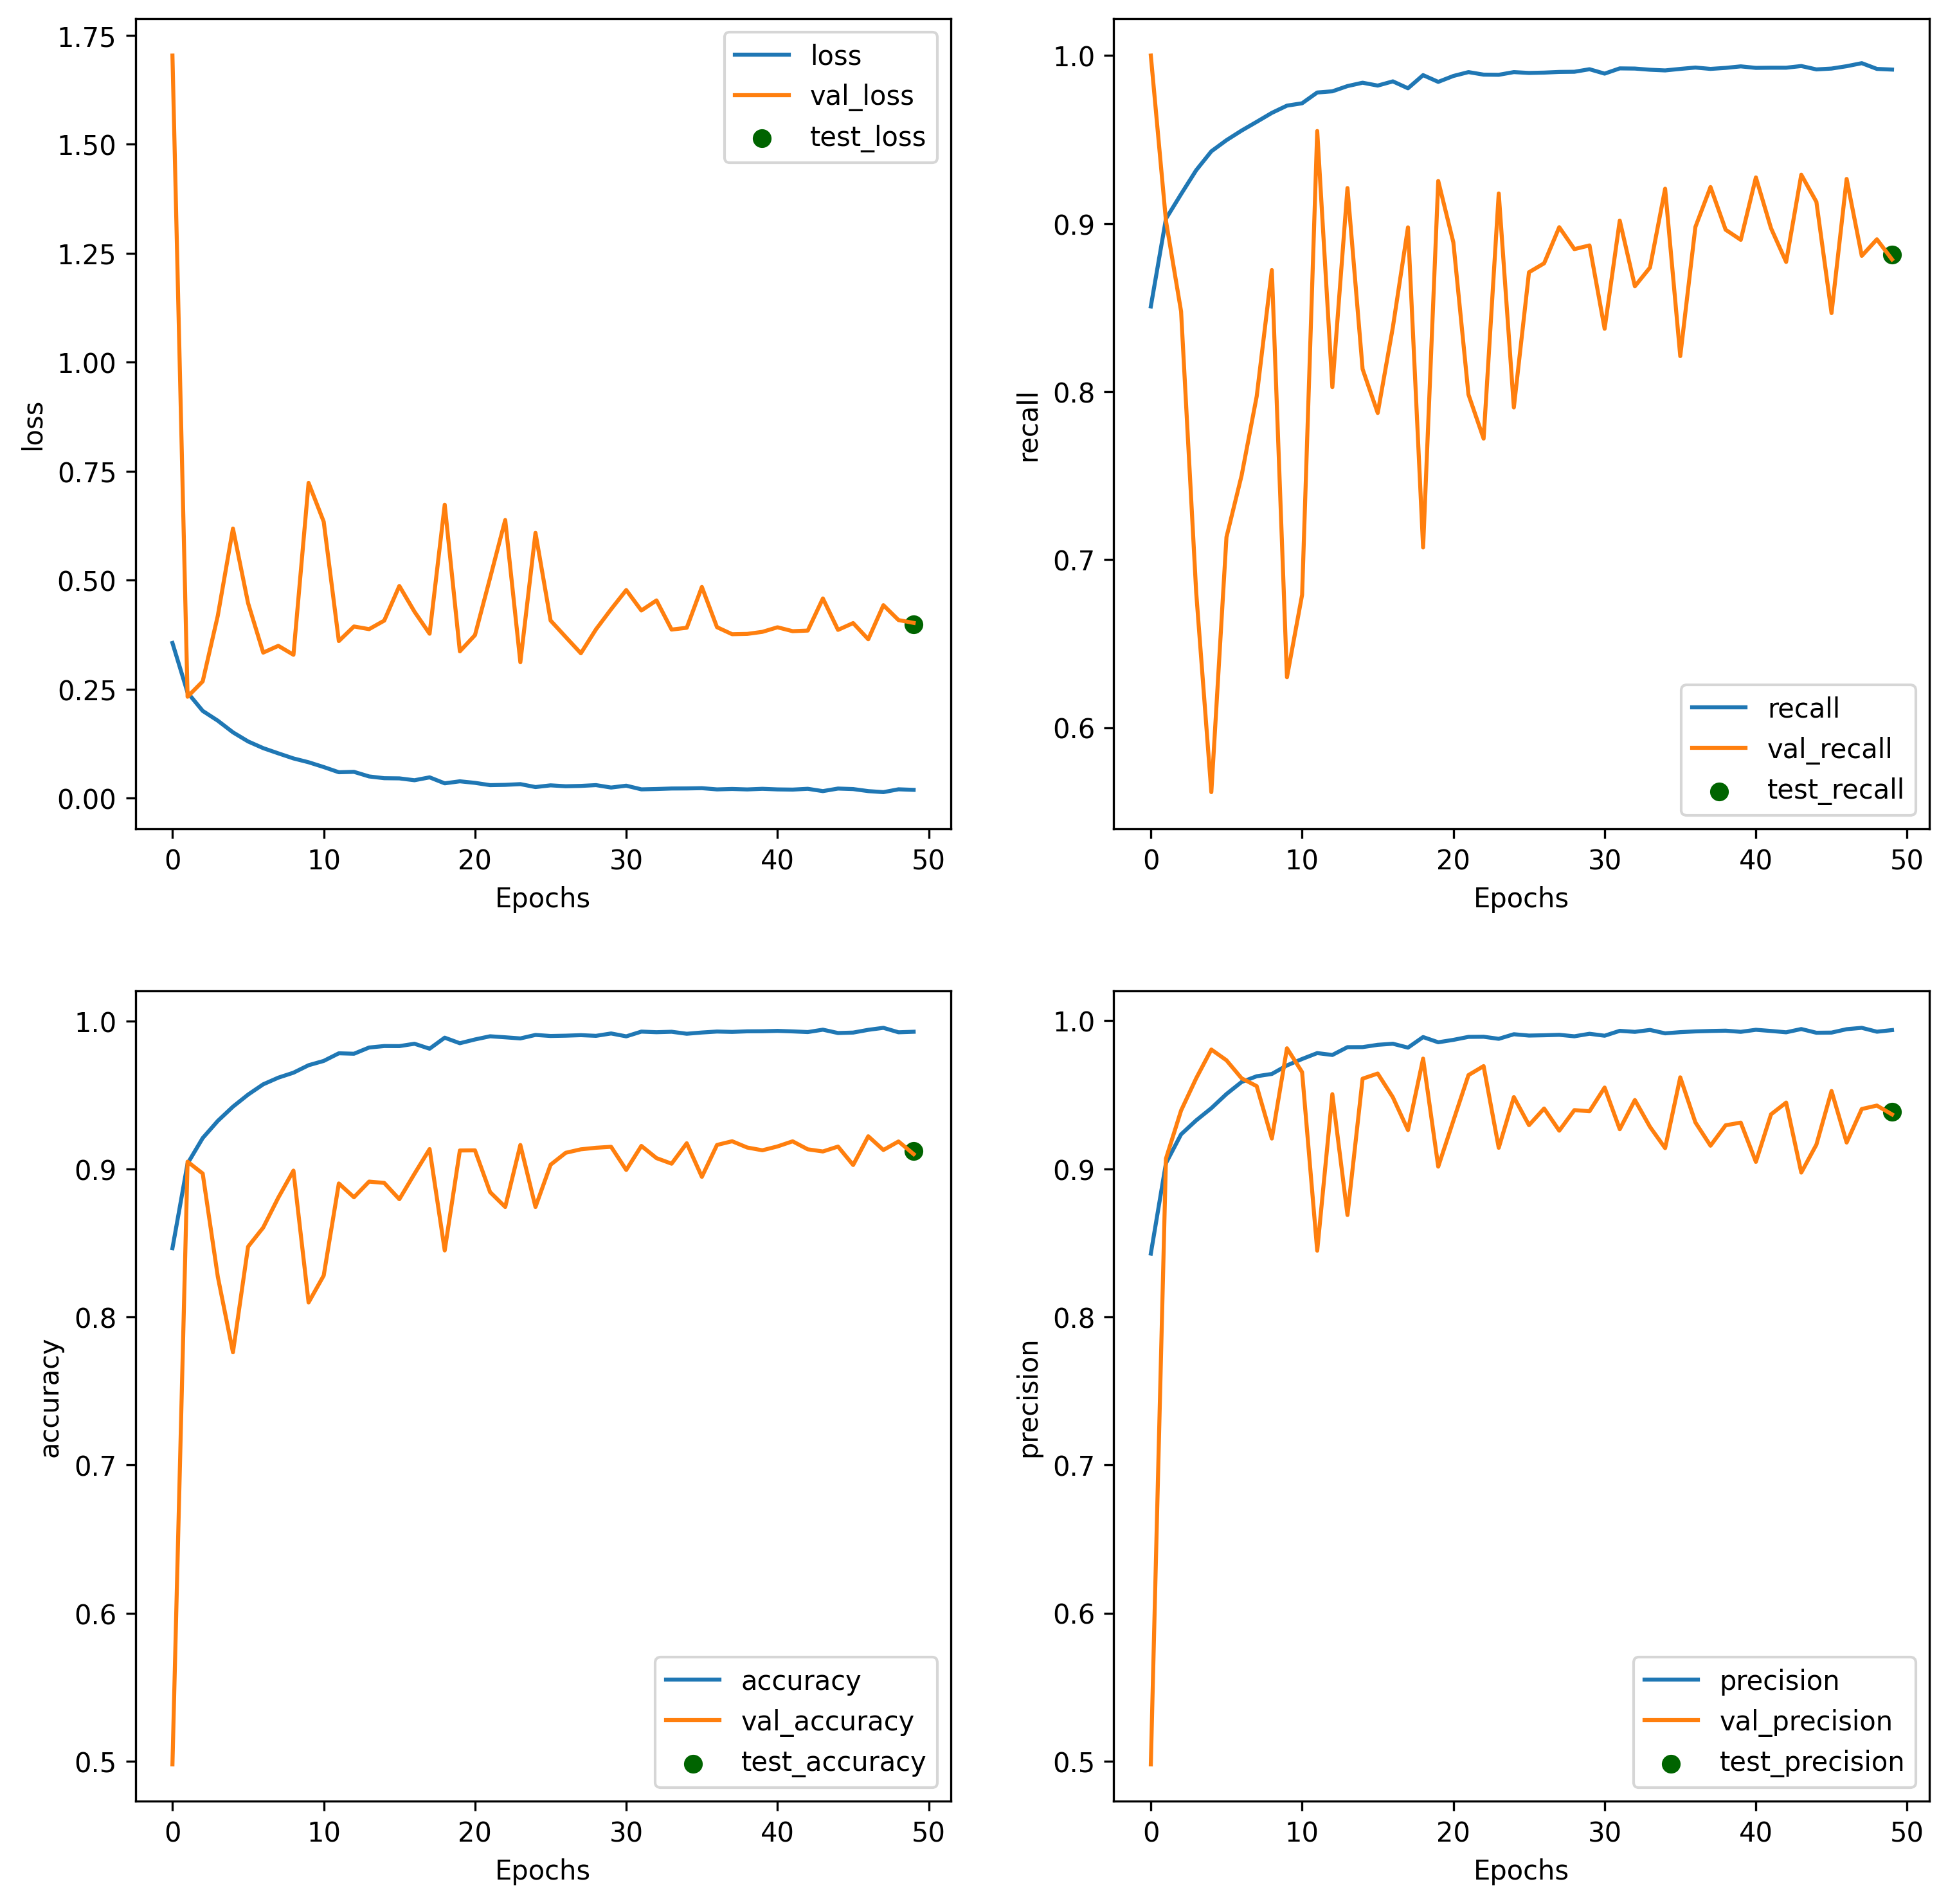

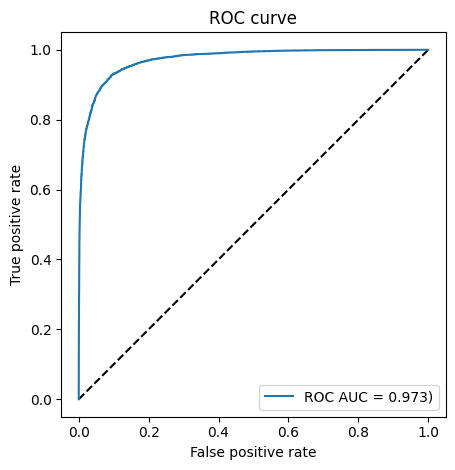

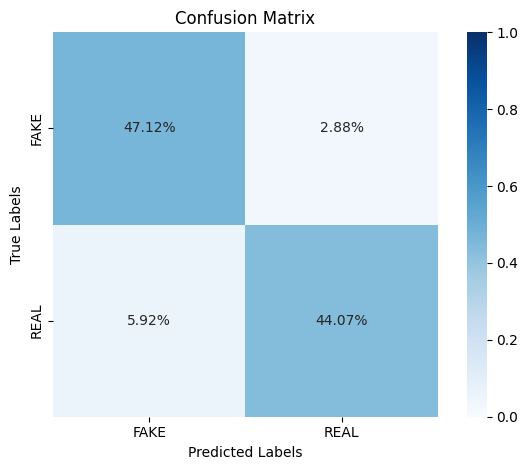

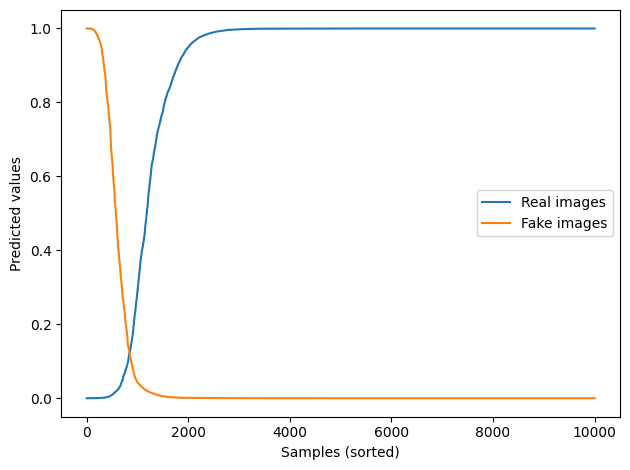

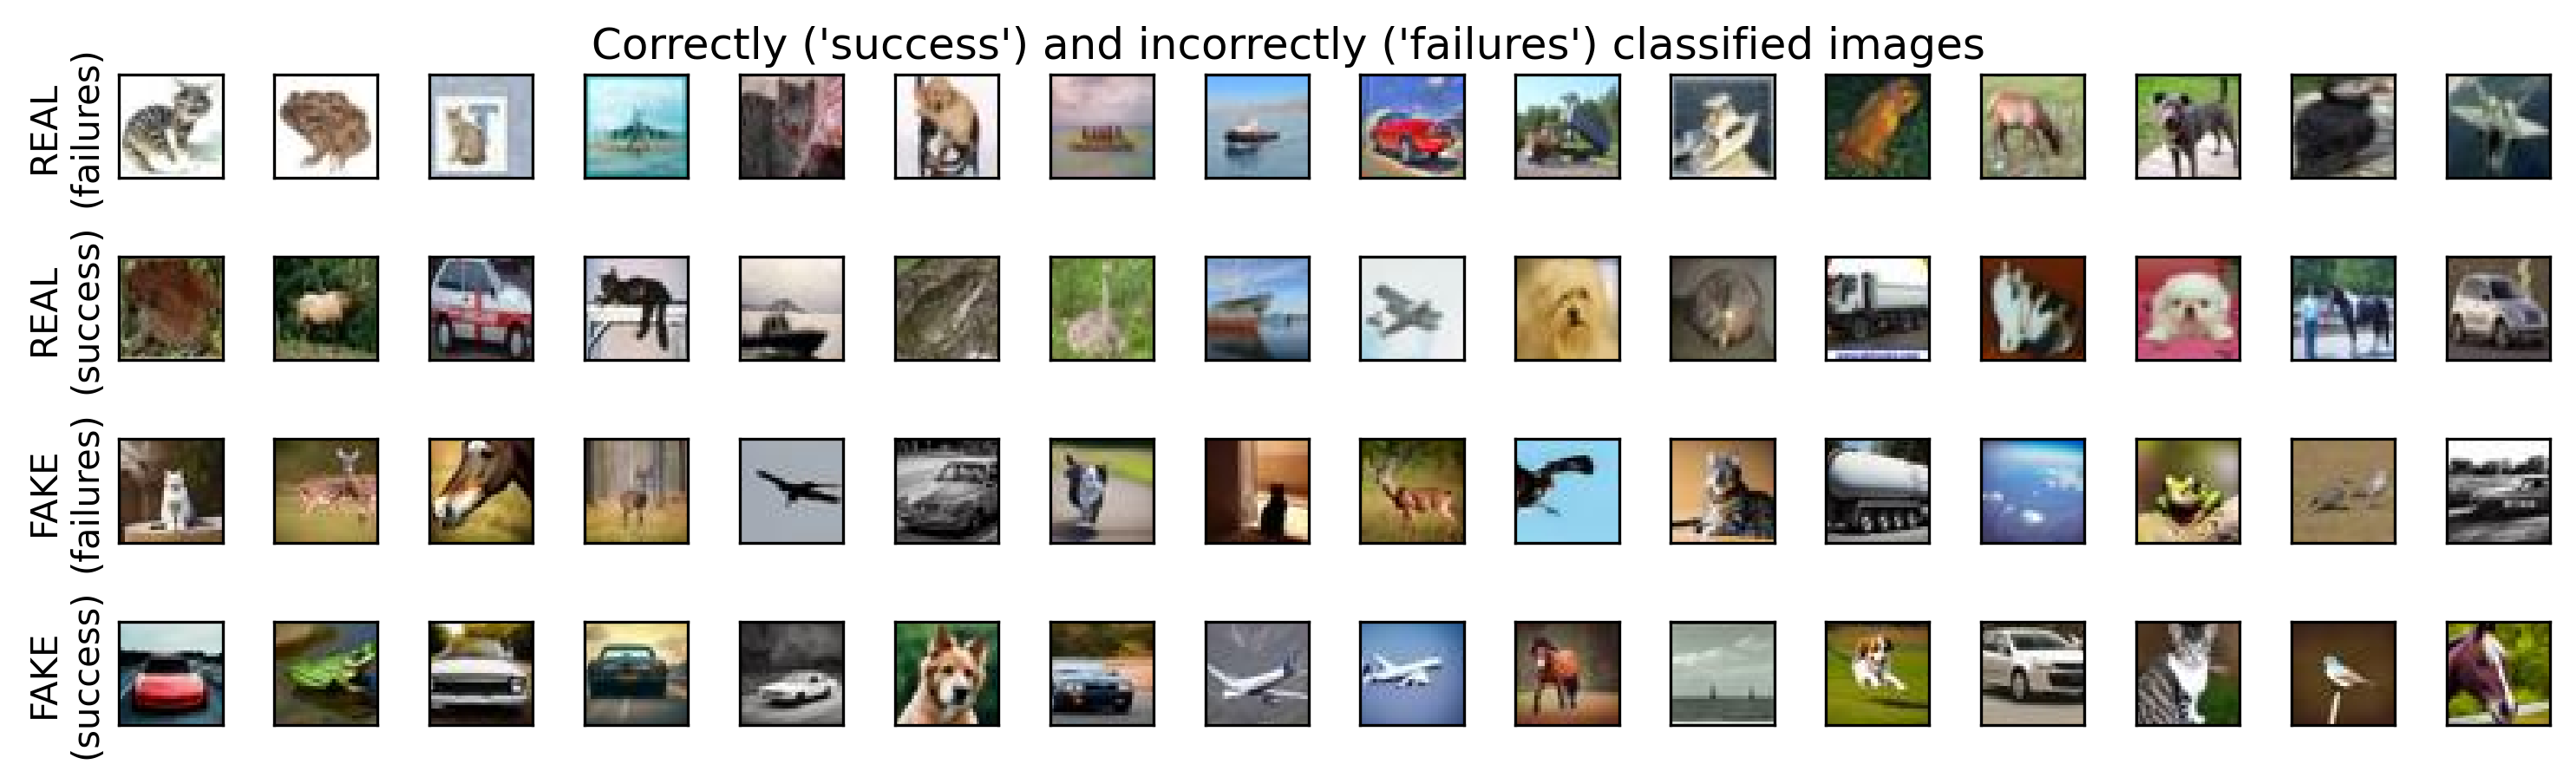

In [39]:
# Plot results
plot_metrics(history, test_loss, test_recall, test_accuracy, test_precision, number_of_epochs)
plot_roc_curve(labels, predicted_values)
plot_confusion_matrix(labels, predicted_classes, test_set_dataloader.class_names)
plot_predicted_values_per_class(predicted_values, labels)
plot_extreme_predictions(predicted_values, labels)

# Summary of key findings

* Despite their relatively tiny size (32×32 pixels), the `REAL` and `FAKE` images can be well distinguished.
* By plotting the sorted probablity for each classification, we can appreciate that most of the samples are classified with a correct and nearly full probability, whereas only the end of the tail shows a steep decrease in confidence and correctness. Notably, the plateau of wrongly classified images with full probability is extremely short.
* By plotting the 16 most correctly and incorrectly classified images for each class, the human operator can visually assess the performance of the approach.
* Model 1 is a small (2.3k parameters, only 8 channels) single-layer convolutional network that can already achieve a respectable score (ROC AUC: 0.951). This establishes a baseline.
* Model 2 is a medium-sized (1.2M parameters) multi-layers convolutional network that achieves the best overall score (ROC AUC: 0.989).
* Model 3 is a medium-sized (2.1M parameters) neural network with mostly dense connections that achieves a slightly suboptimal score (ROC AUC: 0.973).
* Model 4 is a U-Net Xception-style network with an encoder-decoder architecture and residual connections and optimized for efficiency (2.3M parameters), but surprisingly can only achieve a slightly suboptimal score (ROC AUC: 0.973).

# Potential flaws of the current analysis and possible future improvements

* An extensive hyperparameter optimization of the optimizer could slightly contribute to improve the results.
* The effect of JPEG compression may be different between the `REAL` and `FAKE` samples, which could potentially help the classifier to distinguish between the two classes. An analysis of the potential structure created by JPEG compression is out of the scope of the present study by may constitute a relevant future step.
* A similar approach could be ported to full-resolution images, at the cost of a heavier amount of data to process and substantially longer training times.
* The present study focuses on ten semantic classes of images (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). It would be relevant to increase the diversity. One first step in this direction would be to adopt a 10-fold leave-one-out strategy, with one semantic class systematically absent from the training dataset and only evaluated in the test set.
* Taking a different standpoint, an adversarial strategy could be carried out to generate synthetic images that only approach a 50% probability (therefore, optimal) of correct classification.